In [47]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta
from dateutil.parser import parse
from pulp import *
import numpy as np
from sklearn import linear_model
import os.path
from os import path
import seaborn as sns
from draft_kings.data import Sport
from draft_kings.client import contests
from draft_kings.client import available_players
from draft_kings.client import draft_group_details
from draft_kings.client import draftables

In [ ]:
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)

In [4]:
client.player_box_scores(day=1, month=1, year=2020, output_type = OutputType.CSV, output_file_path = "./AllCSVs/1_1_2020_box_scores.csv")

UnicodeEncodeError: 'charmap' codec can't encode character '\u010d' in position 19: character maps to <undefined>

In [2]:
all_tables = []
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

In [3]:
full_df = all_tables[0]
for i in range(1, len(all_tables)):
    current_table = all_tables[i]
    full_df = full_df.append(current_table)
full_df.to_csv("./OutputCSVs/all_games.csv")

In [4]:
df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
df["team"] = df["team"].str.upper()
all_games = pd.read_csv("./OutputCSVs/all_games.csv")

team_def = []
team_pace = []
team_tov = []
opp_def = []
opp_pace = []
opp_tov = []
all_games_teams = all_games[["team", "opponent"]]

for i in range(len(all_games_teams)):
    game = all_games_teams.loc[i]
    team = game["team"]
    opponent = game["opponent"]
    team_def.append(df[df["team"] == team]["drtg"].iloc[0])
    team_pace.append(df[df["team"] == team]["pace"].iloc[0])
    team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
    opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
    opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
    opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
all_games["Team Defensive Rating"] = team_def
all_games["Team Pace"] = team_pace
all_games["Team Turnover %"] = team_tov
all_games["Opponent Defensive Rating"] = opp_def
all_games["Opponent Pace"] = opp_pace
all_games["Opponent Turnover %"] = opp_tov

all_games.to_csv("./OutputCSVs/all_games_new.csv")
df = pd.read_csv("./OutputCSVs/all_games_new.csv")
attempted_2s = df["attempted_field_goals"] - df["attempted_three_point_field_goals"]
made_2s = df["made_field_goals"] - df["made_three_point_field_goals"]
rebounds = df["offensive_rebounds"] + df["defensive_rebounds"]
at_home = df["location"] == "HOME"
df["attempted_two_point_field_goals"] = attempted_2s
df["made_two_point_field_goals"] = made_2s
df["total_rebounds"] = rebounds
df["at_home"] = at_home
df.to_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual = pd.read_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual =  all_games_actual.iloc[:, 3:].reset_index()

In [5]:
def get_stats(player, date, number_rows):
    converted_datetime = datetime.strptime(date, '%Y-%m-%d')
    player_rows = all_games_actual.loc[all_games_actual['name'] == player]
    #print(player_rows)
    selected_rows = []
    if (len(player_rows)) < number_rows:
        for i in range(len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
        return pd.DataFrame(selected_rows)
    index = 0
    for i in range(len(player_rows)):
        curr_date = player_rows.iloc[i]['Date']
        if datetime.strptime(curr_date, '%Y-%m-%d') >= converted_datetime:
            index = i - 1
            break
    if index != 0:
        if index + 1 - number_rows < 0:
            for i in range(index + 1):
                selected_rows.append(player_rows.iloc[i])
        else:
            for i in range(index + 1 - number_rows, index + 1):
                selected_rows.append(player_rows.iloc[i])
#     elif converted_datetime >= players_rows[len(player_rows) - 1]:
    else:
        for i in range(len(player_rows) - number_rows, len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
    return pd.DataFrame(selected_rows)

In [87]:
def get_points(row_data):
    if 'made_three_point_field_goals_y' in row_data.columns:
        three_pt_fgs = row_data['made_three_point_field_goals_y']
        two_pt_fgs = row_data['made_two_point_field_goals_y']
        made_fts = row_data['made_free_throws_y']
        total_rebounds = row_data['rebounds_y']
        assists = row_data['assists_y']
        blocks = row_data['blocks_y']
        steals = row_data['steals_y']
        turnovers = row_data['turnovers_y']
    else:
        three_pt_fgs = row_data['made_three_point_field_goals']
        two_pt_fgs = row_data['made_two_point_field_goals']
        made_fts = row_data['made_free_throws']
        total_rebounds = row_data['rebounds']
        assists = row_data['assists']
        blocks = row_data['blocks']
        steals = row_data['steals']
        turnovers = row_data['turnovers']
    FD_points = three_pt_fgs * 3 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.2 + assists * 1.5 + blocks * 3 + steals * 3 - turnovers
    FD_dollars = FD_points * 200
    return (FD_points, FD_dollars)

def double_double(threes, twos, fts, rebounds, assists):
    points = float(threes) * 3 + float(twos) * 2 + float(fts)
    return (points >= 10 and float(rebounds) >= 10) or (points >= 10 and float(assists) >= 10) or (float(rebounds) >= 10 and float(assists) >= 10)

def triple_double(threes, twos, fts, rebounds, assists):
    points = float(threes) * 3 + float(twos) * 2 + float(fts)
    return points >= 10 and float(rebounds) >= 10 and float(assists) >= 10

def get_draftkings_points(row_data):
    if 'made_three_point_field_goals_y' in row_data.columns:
        three_pt_fgs = row_data['made_three_point_field_goals_y']
        two_pt_fgs = row_data['made_two_point_field_goals_y']
        made_fts = row_data['made_free_throws_y']
        total_rebounds = row_data['rebounds_y']
        assists = row_data['assists_y']
        blocks = row_data['blocks_y']
        steals = row_data['steals_y']
        turnovers = row_data['turnovers_y']
    else:
        three_pt_fgs = row_data['made_three_point_field_goals']
        two_pt_fgs = row_data['made_two_point_field_goals']
        made_fts = row_data['made_free_throws']
        total_rebounds = row_data['rebounds']
        assists = row_data['assists']
        blocks = row_data['blocks']
        steals = row_data['steals']
        turnovers = row_data['turnovers']
    DK_points = three_pt_fgs * 3.5 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.25 + assists * 1.5 + blocks * 2 + steals * 2 - .5 * turnovers + 1.5 * double_double(three_pt_fgs, two_pt_fgs, made_fts, rebounds, assists) + 3 * triple_double(three_pt_fgs, two_pt_fgs, made_fts, rebounds, assists)
    DK_dollars = DK_points * 166.66
    return (DK_points, DK_dollars)

In [7]:
def weight_function(statistic, weight):
    s = 0
    if type(statistic) == np.ndarray:
        for i in range(len(statistic)):
            s += statistic[len(statistic) - i - 1] * (weight ** i)
    else:
        for i in range(len(statistic)):
            s += statistic.iloc[len(statistic) - i - 1,] * (weight ** i)
    return s

In [8]:
def time_weighted_average(rows, statistic, weight):
    if rows.empty:
        return 0
    stat = rows[statistic]
    this_num = 1 / weight_function(np.ones(len(stat)), weight)
    return this_num * weight_function(stat, weight)
player_box_scores = pd.read_csv('./OutputCSVs/all_games_updated.csv')

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']

In [9]:
def statline_predictor(player_box_scores, input_statistics, sample_size = 5, weight = .8):
    player_box_scores = player_box_scores[~player_box_scores.index.duplicated()]
    player_box_scores.reindex(range(len(player_box_scores)), axis = "index")
    predicted_statlines = pd.DataFrame(index = player_box_scores.index, columns = input_statistics).fillna(0).T
    index_len = len(player_box_scores.index)
    for box_index in player_box_scores.index:
        box_score = player_box_scores.loc[box_index]
        player_name = box_score["name"]
        game_date = str(box_score["Date"])[:10]
        last_n_rows = get_stats(player_name, game_date, sample_size)
        weighted_stats = [player_name, box_score["team"], game_date, box_score["location"], box_score["opponent"]]
        for stat in input_statistics[5:]:
            weighted_stats.append(round(time_weighted_average(last_n_rows, stat, weight), 2))
        predicted_statlines[box_index] = weighted_stats
    return predicted_statlines.T

In [11]:
predictions_samplesize5 = statline_predictor(all_games_actual, input_statistics, sample_size = 5)
predictions_samplesize5.to_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
predictions_samplesize10 = statline_predictor(all_games_actual, input_statistics, sample_size = 10)
predictions_samplesize10.to_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")

In [10]:
def rebound_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds_y"] + .2874 * weighted_stats["defensive_rebounds_y"]
    else:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds"] + .2874 * weighted_stats["defensive_rebounds"]
def freethrow_predictor_5(weighted_stats):
    if "attempted_free_throws_y" in weighted_stats.index:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws_y"] + -.0373 * weighted_stats["attempted_field_goals_y"] -.3289 * (weighted_stats["location_y"] == "HOME")
    else:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws"] + -.0373 * weighted_stats["attempted_field_goals"] -.3289 * (weighted_stats["location"] == "HOME")
def twopt_predictor_5(weighted_stats):
    if "attempted_field_goals_y" in weighted_stats.index:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals_y"] - .2542 * weighted_stats["attempted_field_goals_y"] + .071 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals"] - .2542 * weighted_stats["attempted_field_goals"] + .071 * weighted_stats["Opponent Defensive Rating"])
def threept_predictor_5(weighted_stats):
    if "attempted_three_point_field_goals_y" in weighted_stats.index:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals_y"]
    else:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals"]
def assist_predictor_5(weighted_stats):
    if "assists_y" in weighted_stats.index:
        return 2.06 + .532 * weighted_stats["assists_y"] - .064 * weighted_stats["blocks_y"]
    else:
        return 2.06 + .532 * weighted_stats["assists"] - .064 * weighted_stats["blocks"]
def block_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return .329 + .182 * weighted_stats["offensive_rebounds_y"] - .038 * weighted_stats["defensive_rebounds_y"] + .424 * weighted_stats["blocks_y"]
    else:
        return .329 + .182 * weighted_stats["offensive_rebounds"] - .038 * weighted_stats["defensive_rebounds"] + .424 * weighted_stats["blocks"]
def steal_predictor_5(weighted_stats):
    if "steals_y" in weighted_stats.index:
        return max(0, -.936 + .339 * weighted_stats["steals_y"] + .129 * weighted_stats["Opponent Turnover %"])
    else:
        return max(0, -.936 + .339 * weighted_stats["steals"] + .129 * weighted_stats["Opponent Turnover %"])
def turnover_predictor_5(weighted_stats):
    if "turnovers_y" in weighted_stats.index:
        return max(0, -2.589 + .18 * weighted_stats["turnovers_y"] + .121 * weighted_stats["assists_y"] + .032 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -2.589 + .18 * weighted_stats["turnovers"] + .121 * weighted_stats["assists"] + .032 * weighted_stats["Opponent Defensive Rating"])
def minutes_predictor(weighted_stats):
    if "seconds_played_y" in weighted_stats.index:
        return np.mean(weighted_stats["seconds_played_y"])/60
    else:
        return np.mean(weighted_stats["seconds_played"])/60
def recent_average(weighted_stats):
    if len(weighted_stats.index) == 0:
        return 0
    if "made_three_point_field_goals_y" in weighted_stats.index:
        return 3*np.mean(weighted_stats["made_three_point_field_goals_y"]) + 2*np.mean(weighted_stats["made_two_point_field_goals_y"]) + np.mean(weighted_stats["made_free_throws_y"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds_y"]) + np.mean(weighted_stats["defensive_rebounds_y"])) + 1.5*np.mean(weighted_stats["assists_y"]) + 3*np.mean(weighted_stats["blocks_y"]) + 3*np.mean(weighted_stats["steals_y"]) - np.mean(weighted_stats["turnovers_y"])
    else:
        return 3*np.mean(weighted_stats["made_three_point_field_goals"]) + 2*np.mean(weighted_stats["made_two_point_field_goals"]) + np.mean(weighted_stats["made_free_throws"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds"]) + np.mean(weighted_stats["defensive_rebounds"])) + 1.5*np.mean(weighted_stats["assists"]) + 3*np.mean(weighted_stats["blocks"]) + 3*np.mean(weighted_stats["steals"]) - np.mean(weighted_stats["turnovers"])

In [13]:
all_games_predicted_5 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
all_games_predicted_5 = all_games_predicted_5.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_5 = all_games_actual.merge(all_games_predicted_5, left_on="index", right_on="indexr")
all_games_predicted_10 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")
all_games_predicted_10 = all_games_predicted_10.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_10 = all_games_actual.merge(all_games_predicted_10, left_on="index", right_on="indexr")
all_games_merged_5.to_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")
all_games_merged_10.to_csv("./OutputCSVs/true_and_predicted_statlines_10.csv")

In [14]:
weighted_preds = pd.read_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")

In [39]:
from sklearn.linear_model import RidgeCV

output_statistics = ["name", "team", "date", "location", "opponent", "minutes", "made_two_point_field_goals", "made_three_point_field_goals", "made_free_throws", "rebounds", "assists", "blocks", "steals", "turnovers", "recent_average", "10_game_average", "3_game_average", "10_3_ratio", "10_3_difference", "hot", "cold", "fantasy_points"]

def statline_output(player_box_scores, input_statistics):
    weighted_lines_7_9 = statline_predictor(player_box_scores, input_statistics, 7, .9)
    weighted_lines_8_8 = statline_predictor(player_box_scores, input_statistics, 8, .8)
    weighted_lines_8_85 = statline_predictor(player_box_scores, input_statistics, 8, .85)
    weighted_lines_8_9 = statline_predictor(player_box_scores, input_statistics, 8, .9)
    weighted_lines_to_keep_7_9 = weighted_lines_7_9[weighted_lines_7_9.seconds_played > 1000]
    weighted_lines_to_keep_8_8 = weighted_lines_8_8[weighted_lines_8_8.seconds_played > 1000]
    weighted_lines_to_keep_8_85 = weighted_lines_8_85[weighted_lines_8_85.seconds_played > 1000]
    weighted_lines_to_keep_8_9 = weighted_lines_8_9[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep = player_box_scores[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_lines_to_keep_7_9['name_date'] = weighted_lines_to_keep_7_9["name"] + weighted_lines_to_keep_7_9["date"].astype(str)
    weighted_lines_to_keep_8_8['name_date'] = weighted_lines_to_keep_8_8["name"] + weighted_lines_to_keep_8_8["date"].astype(str)
    weighted_lines_to_keep_8_85['name_date'] = weighted_lines_to_keep_8_85["name"] + weighted_lines_to_keep_8_85["date"].astype(str)
    weighted_lines_to_keep_8_9['name_date'] = weighted_lines_to_keep_8_9["name"] + weighted_lines_to_keep_8_9["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged_7_9 = weighted_lines_to_keep_7_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_7_9["rebounds_y"] = df_merged_7_9["offensive_rebounds_y"] + df_merged_7_9["defensive_rebounds_y"]
    df_merged_7_9["location_x"] = df_merged_7_9["location_x"] == "HOME"
    df_merged_7_9["location_y"] = df_merged_7_9["location_y"] == "HOME"
    df_merged_8_8 = weighted_lines_to_keep_8_8.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_8["rebounds_y"] = df_merged_8_8["offensive_rebounds_y"] + df_merged_8_8["defensive_rebounds_y"]
    df_merged_8_8["location_x"] = df_merged_8_8["location_x"] == "HOME"
    df_merged_8_8["location_y"] = df_merged_8_8["location_y"] == "HOME"
    df_merged_8_85 = weighted_lines_to_keep_8_85.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_85["rebounds_y"] = df_merged_8_85["offensive_rebounds_y"] + df_merged_8_85["defensive_rebounds_y"]
    df_merged_8_85["location_x"] = df_merged_8_85["location_x"] == "HOME"
    df_merged_8_85["location_y"] = df_merged_8_85["location_y"] == "HOME"
    df_merged_8_9 = weighted_lines_to_keep_8_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_9["rebounds_y"] = df_merged_8_9["offensive_rebounds_y"] + df_merged_8_9["defensive_rebounds_y"]
    df_merged_8_9["location_x"] = df_merged_8_9["location_x"] == "HOME"
    df_merged_8_9["location_y"] = df_merged_8_9["location_y"] == "HOME"
    predictors_7_9 = df_merged_7_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_8 = df_merged_8_8.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_85 = df_merged_8_85.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_9 = df_merged_8_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    df_merged_7_9["fantasy_points"] = [float(get_points(df_merged_7_9[df_merged_7_9["name_date"] == player_name])[0]) for player_name in df_merged_7_9["name_date"]]
    df_merged_8_8["fantasy_points"] = [float(get_points(df_merged_8_8[df_merged_8_8["name_date"] == player_name])[0]) for player_name in df_merged_8_8["name_date"]]
    df_merged_8_85["fantasy_points"] = [float(get_points(df_merged_8_85[df_merged_8_85["name_date"] == player_name])[0]) for player_name in df_merged_8_85["name_date"]]
    df_merged_8_9["fantasy_points"] = [float(get_points(df_merged_8_9[df_merged_8_9["name_date"] == player_name])[0]) for player_name in df_merged_8_9["name_date"]]
    fantasy_points_8_9 = df_merged_8_9.iloc[:,58]
    freethrows = df_merged_7_9.iloc[:,38]
    twopoints = df_merged_8_8.iloc[:,56]
    threepoints = df_merged_8_85.iloc[:,36]
    blocks = df_merged_8_85.iloc[:,44]
    assists = df_merged_8_9.iloc[:,42]
    rebounds = df_merged_8_9.iloc[:,57]
    turnovers = df_merged_8_9.iloc[:,45]
    seconds = df_merged_8_9.iloc[:,33]
    steals = df_merged_8_9.iloc[:,43]
    fantasy_model_8_9 = RidgeCV().fit(predictors_8_9, fantasy_points_8_9)
    freethrow_model = RidgeCV().fit(predictors_7_9, freethrows)
    twopoint_model = RidgeCV().fit(predictors_8_8, twopoints)
    threepoint_model = RidgeCV().fit(predictors_8_85, threepoints)
    block_model = RidgeCV().fit(predictors_8_85, blocks)
    assist_model = RidgeCV().fit(predictors_8_9, assists)
    rebound_model = RidgeCV().fit(predictors_8_9, rebounds)
    turnover_model = RidgeCV().fit(predictors_8_9, turnovers)
    second_model = RidgeCV().fit(predictors_8_9, seconds)
    steal_model = RidgeCV().fit(predictors_8_9, steals)

    
    output_statlines = pd.DataFrame(index = weighted_lines_8_9.index, columns = output_statistics).fillna(0)
    output_statlines["name"] = weighted_lines_8_9["name"]
    output_statlines["team"] = weighted_lines_8_9["team"]
    output_statlines["date"] = weighted_lines_8_9["date"]
    output_statlines["location"] = weighted_lines_8_9["location"]
    output_statlines["opponent"] = weighted_lines_8_9["opponent"]
    weighted_lines_7_9["location"] = weighted_lines_7_9["location"] == "HOME"
    weighted_lines_8_8["location"] = weighted_lines_8_8["location"] == "HOME"
    weighted_lines_8_85["location"] = weighted_lines_8_85["location"] == "HOME"
    weighted_lines_8_9["location"] = weighted_lines_8_9["location"] == "HOME"
    weighted_lines_7_9 = weighted_lines_7_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_8 = weighted_lines_8_8.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_85 = weighted_lines_8_85.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_9 = weighted_lines_8_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]

    output_statlines["minutes"] = second_model.predict(weighted_lines_8_9) / 60
    output_statlines["made_two_point_field_goals"] = twopoint_model.predict(weighted_lines_8_8)
    output_statlines["made_three_point_field_goals"] = threepoint_model.predict(weighted_lines_8_85) 
    output_statlines["made_free_throws"] = freethrow_model.predict(weighted_lines_7_9)
    output_statlines["rebounds"] = rebound_model.predict(weighted_lines_8_9)
    output_statlines["assists"] = assist_model.predict(weighted_lines_8_9)
    output_statlines["blocks"] = block_model.predict(weighted_lines_8_85)
    output_statlines["steals"] = steal_model.predict(weighted_lines_8_9) 
    output_statlines["turnovers"] = turnover_model.predict(weighted_lines_8_9)
    output_statlines["fantasy_points_8_9"] = fantasy_model_8_9.predict(weighted_lines_8_9)
    for box_index in output_statlines.index:
        pred_minutes = max(0, output_statlines.loc[box_index, "minutes"])
        if pred_minutes <= 19:
            output_statlines.loc[box_index, "made_two_point_field_goals"] = output_statlines.loc[box_index, "made_two_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_three_point_field_goals"] = output_statlines.loc[box_index, "made_three_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_free_throws"] = output_statlines.loc[box_index, "made_free_throws"] * pred_minutes/19
            output_statlines.loc[box_index, "rebounds"] = output_statlines.loc[box_index, "rebounds"] * pred_minutes/19
            output_statlines.loc[box_index, "assists"] = output_statlines.loc[box_index, "assists"] * pred_minutes/19
            output_statlines.loc[box_index, "blocks"] = output_statlines.loc[box_index, "blocks"] * pred_minutes/19
            output_statlines.loc[box_index, "steals"] = output_statlines.loc[box_index, "steals"] * pred_minutes/19
            output_statlines.loc[box_index, "turnovers"] = output_statlines.loc[box_index, "turnovers"] * pred_minutes/19
        output_statlines.loc[box_index, "minutes"] = pred_minutes
        output_statlines.loc[box_index, "made_two_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_two_point_field_goals"])
        output_statlines.loc[box_index, "made_three_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_three_point_field_goals"])
        output_statlines.loc[box_index, "made_free_throws"] = max(0, output_statlines.loc[box_index, "made_free_throws"])
        output_statlines.loc[box_index, "rebounds"] = max(0, output_statlines.loc[box_index, "rebounds"])
        output_statlines.loc[box_index, "assists"] = max(0, output_statlines.loc[box_index, "assists"])
        output_statlines.loc[box_index, "blocks"] = max(0, output_statlines.loc[box_index, "blocks"])
        output_statlines.loc[box_index, "steals"] = max(0, output_statlines.loc[box_index, "steals"])
        output_statlines.loc[box_index, "turnovers"] = max(0, output_statlines.loc[box_index, "turnovers"])
        output_statlines.loc[box_index, "recent_average"] = np.mean([recent_average(weighted_lines_8_85.loc[box_index]), recent_average(weighted_lines_8_9.loc[box_index]), recent_average(weighted_lines_8_8.loc[box_index]), recent_average(weighted_lines_7_9.loc[box_index])])
        last_10_games = get_stats(output_statlines.loc[box_index, "name"], output_statlines.loc[box_index, "date"], 10)
        last_3_games = get_stats(output_statlines.loc[box_index, "name"], output_statlines.loc[box_index, "date"], 3)
        output_statlines.loc[box_index, "10_game_average"] = recent_average(last_10_games)
        output_statlines.loc[box_index, "3_game_average"] = recent_average(last_3_games)
        output_statlines.loc[box_index, "10_3_ratio"] = (output_statlines.loc[box_index, "10_game_average"] + 1)/(output_statlines.loc[box_index, "3_game_average"] + 1)
        output_statlines.loc[box_index, "10_3_difference"] = output_statlines.loc[box_index, "10_game_average"] - output_statlines.loc[box_index, "3_game_average"]
        output_statlines.loc[box_index, "hot"] = np.log(((-7 * min(0, output_statlines.loc[box_index, "10_3_ratio"] - .83)) * (-1 * min(0, output_statlines.loc[box_index, "10_3_difference"] + 6))) + 1)
        output_statlines.loc[box_index, "cold"] = np.log(((7 * max(0, output_statlines.loc[box_index, "10_3_ratio"] - 1.22)) * (max(0, output_statlines.loc[box_index, "10_3_difference"] - 6.5))) + 1)
        
    return output_statlines

#make_predictions(datetime(2020, 1, 20), datetime(2020, 2, 21), output = False)

In [22]:
jan_feb_data = pd.read_csv('./OutputCSVs/predicted_statlines_jan_feb_2020.csv')
FD_points_array = []
FD_dollars_array = []
sum_points = 0
counter = 0
for index, row in jan_feb_data.iterrows():
    tuple_values = get_points(row)
    FD_points_array.append(tuple_values[0])
    FD_dollars_array.append(tuple_values[1])
    sum_points += tuple_values[0]
    counter += 1
jan_feb_data['FanDuel_Points'] = FD_points_array
jan_feb_data['FanDuel_Dollars'] = FD_dollars_array
jan_feb_data.to_csv("./OutputCSVs/Jan_Feb_statline_with_FanDuel_dollars.csv")

In [13]:
def generate_optimal_lineup(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    for i in range(0, len(positions)):
        if positions[i] == "PG":
            pg_constraint += d[players[i]]
        elif positions[i] == "SG":
            sg_constraint += d[players[i]]
        elif positions[i] == "SF":
            sf_constraint += d[players[i]]
        elif positions[i] == "PF":
            pf_constraint += d[players[i]]
        else:
            c_constraint += d[players[i]]
    lp += pg_constraint == 2
    lp += sg_constraint == 2
    lp += sf_constraint == 2
    lp += pf_constraint == 2
    lp += c_constraint == 1
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    return lineup
    #for variable in lp.variables():
    #    print ("{} = {}".format(variable.name, variable.varValue))
    #print(pulp.value(lp.objective))

In [14]:
def box_scores_for_range_of_days(start_date, end_date):
    all_tables = []
    start_month = start_date.month
    end_month = end_date.month
    for m in range(start_month, end_month + 1):
        if m == start_month:
            start_day = start_date.day
        else:
            start_day = 1
        if m == end_month:
            end_day = end_date.day
        else:
            if m == 2:
                end_day = 29
            elif m in [9, 4, 6, 11]:
                end_day = 30
            else:
                end_day = 31
        
        for d in range(start_day, end_day + 1):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            if not path.exists(file_name):
                continue
            if pd.read_csv(file_name).empty:
                client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
            table = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    
    full_df.index = range(full_df.shape[0])
    df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
    df["team"] = df["team"].str.upper()

    team_def = []
    team_pace = []
    team_tov = []
    opp_def = []
    opp_pace = []
    opp_tov = []
    all_games_teams = full_df[["team", "opponent"]]

    for i in range(len(all_games_teams)):
        game = all_games_teams.loc[i]
        team = game["team"].upper()
        opponent = game["opponent"].upper()
        team_def.append(df[df["team"] == team]["drtg"].iloc[0])
        team_pace.append(df[df["team"] == team]["pace"].iloc[0])
        team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
        opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
        opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
        opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
    full_df["Team Defensive Rating"] = team_def
    full_df["Team Pace"] = team_pace
    full_df["Team Turnover %"] = team_tov
    full_df["Opponent Defensive Rating"] = opp_def
    full_df["Opponent Pace"] = opp_pace
    full_df["Opponent Turnover %"] = opp_tov
    return full_df

In [15]:
def make_predictions(start_date, end_date, output = True):
    input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']
    full_df = box_scores_for_range_of_days(start_date, end_date)
    predicted_statlines = statline_output(full_df, input_statistics)
    if output:
        output_filename = './AllCSVs/' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(end_date.month) + '_' + str(end_date.day) + '_2020_predicted_box_scores.csv'
        predicted_statlines.to_csv(output_filename)
    return predicted_statlines

In [17]:
import pytz

def predict_next_day(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and game['start_time'].month == game_date.month]
    team_objs_on_date = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    teams_on_date = [t.name.replace("_", " ") for t in team_objs_on_date]
    predictions_for_date = make_predictions(start_date, game_date, output = False)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(teams_on_date)]
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = mstr + "-" + dstr
    statlines_on_date = players_on_date[players_on_date.date.str.contains(tstr)]
    statlines_on_date.index = range(statlines_on_date.shape[0])
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + '_from_' + str(start_date.month) + '_' + str(start_date.day) + '_2020.csv'
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
#feb_28_predictions = predict_next_day(datetime(2020, 1, 27), datetime(2020, 2, 28))

In [18]:
def append_actual_results(start_date, game_date):
    predicted_results = predict_next_day(start_date, game_date)
    actual_results = box_scores_for_range_of_days(game_date, game_date)
    actual_results["made_two_point_field_goals"] = actual_results["made_field_goals"] - actual_results["made_three_point_field_goals"]
    actual_results["rebounds"] = actual_results["offensive_rebounds"] + actual_results["defensive_rebounds"]
    pred_outputs = [float(get_points(predicted_results[predicted_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    actual_outputs = [float(get_points(actual_results[actual_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    predicted_results["predicted_points"] = pred_outputs
    predicted_results["actual_points"] = actual_outputs
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_box_scores_predicted_with_actual.csv'
    predicted_results.to_csv(output_filename)
    return predicted_results

#append_actual_results(datetime(2020, 2, 1), datetime(2020, 2, 12))

In [19]:
def alternate_contests(start_date, game_date, search_datetime, inclusive):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    times_on_date = np.unique([game['start_time'] - timedelta(hours = 4) for game in schedule_on_date])
    print(times_on_date)
    if not inclusive:
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime]
    else:
        times_after_search = [t for t in times_on_date if 60 * t.hour + t.minute >= 60 * search_datetime.hour + search_datetime.minute]
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    predictions_for_date = predict_next_day(start_date, game_date)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(game_team_strings)]
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_alternate_' + str(search_datetime.hour) + "_" + str(search_datetime.minute) + '.csv'
    players_on_date.to_csv(output_filename)
    return players_on_date
#alternate_contests(datetime(2020, 1, 1), datetime(2020, 1, 13), datetime(2020, 1, 13, 21, 30), True)

In [88]:
def matchup_lookup(matchups, team):
    matchup = [m for m in matchups if team in m][0]
    if team == matchup[0]:
        return matchup[1]
    else:
        return matchup[0]

def predict_unplayed_games(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    available_box_scores = box_scores_for_range_of_days(start_date, game_date)
    game_teams = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    matchups = [[str(game["home_team"])[5:].replace("_", " "), str(game["away_team"])[5:].replace("_", " ")] for game in schedule_on_date]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    relevant_lines = available_box_scores[available_box_scores.team.isin(game_team_strings)]
    relevant_players = relevant_lines.drop_duplicates(subset = ["name"])
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = str(game_date.year) + "-" + mstr + "-" + dstr
    relevant_players.Date = [tstr for _ in range(len(relevant_players))]
    relevant_players.location = ["AWAY" for _ in range(len(relevant_players))]
    relevant_players.opponent = [matchup_lookup(matchups, t) for t in relevant_players.team]
    augmented_box_scores = available_box_scores.append(relevant_players)
    augmented_box_scores.index = range(augmented_box_scores.shape[0])
    predicted_statlines = statline_output(augmented_box_scores, input_statistics)
    statlines_on_date = predicted_statlines[predicted_statlines.date.str.contains(tstr)]
    statlines_on_date['projected_points'] = [float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]) for player_name in statlines_on_date.name]
    statlines_on_date['projected_points_draftkings'] = [float(get_draftkings_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]) for player_name in statlines_on_date.name]
    statlines_on_date['projected_value'] = [float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[1]) for player_name in statlines_on_date.name]
    statlines_on_date['projected_value_draftkings'] = [float(get_draftkings_points(statlines_on_date[statlines_on_date["name"] == player_name])[1]) for player_name in statlines_on_date.name]
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + "_2020_unplayed.csv"
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
    
july_30_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 30))
july_30_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

TypeError: cannot convert the series to <class 'float'>

In [56]:
contests(sport=Sport.NBA)
#draftables(draft_group_id=4)
#draft_group_details(draft_group_id=1)
available_players(draft_group_id=4)

{'players': [], 'team_series_list': []}

In [84]:
def optimal_lineup_fanduel_games(game_date, fanduel_csv, players_out):
    fanduel_data = pd.read_csv(fanduel_csv)
    predictions = pd.read_csv("./AllCSVs/predictions_for_07_30_2020_unplayed.csv") #predict_unplayed_games(datetime(2020, 2, 1), game_date)
    print("Done predicting!")
    fanduel_data_with_predictions = fanduel_data.merge(predictions, left_on = "Nickname", right_on = "name")
    fanduel_data_with_predictions_injuries = fanduel_data_with_predictions[fanduel_data_with_predictions["Injury Indicator"] != "O"]
    players_not_out = [(name not in players_out) for name in fanduel_data_with_predictions_injuries["Nickname"]]
    fanduel_data_with_predictions_injuries = fanduel_data_with_predictions_injuries[players_not_out]
    fanduel_data_with_predictions_injuries.index = range(fanduel_data_with_predictions_injuries.shape[0])
    values = fanduel_data_with_predictions_injuries["projected_points"]
    players = fanduel_data_with_predictions_injuries["Nickname"]
    positions = fanduel_data_with_predictions_injuries["Position"]
    costs = fanduel_data_with_predictions_injuries["Salary"]
    data_to_feed = pd.DataFrame(data = {'players': players, 'positions': positions, 'values': values, 'costs': costs})
    return generate_optimal_lineup(players, positions, values, costs, 60000)

fd_csv = "./AllCSVs/FanDuel-NBA-2020-07-30-46677-players-list.csv"
optimal_lineup_fanduel_games(datetime(2020, 7, 30), fd_csv, ["Lou Williams"])

Done predicting!
['Alex_Caruso', 'Anthony_Davis', 'Brandon_Ingram', 'Donovan_Mitchell', 'Dwight_Howard', 'Kentavious_Caldwell_Pope', 'Kyle_Kuzma', 'LeBron_James', 'Lonzo_Ball']


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pulp\pulp.py:1137: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [60]:
july_30_predictions

name                  team        date location  \
4948             Anthony Davis    LOS ANGELES LAKERS  2020-07-30     AWAY   
4949             Kawhi Leonard  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4950          Bojan Bogdanović             UTAH JAZZ  2020-07-30     AWAY   
4951               Paul George  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4952          Donovan Mitchell             UTAH JAZZ  2020-07-30     AWAY   
4953              LeBron James    LOS ANGELES LAKERS  2020-07-30     AWAY   
4954               Rajon Rondo    LOS ANGELES LAKERS  2020-07-30     AWAY   
4955               Mike Conley             UTAH JAZZ  2020-07-30     AWAY   
4956  Kentavious Caldwell-Pope    LOS ANGELES LAKERS  2020-07-30     AWAY   
4957             Avery Bradley    LOS ANGELES LAKERS  2020-07-30     AWAY   
4958               Alex Caruso    LOS ANGELES LAKERS  2020-07-30     AWAY   
4959          Patrick Beverley  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4960          Montrezl Harrell  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4961               Rudy Gobert             UTAH JAZZ  2020-07-30     AWAY   
4962              Lou Williams  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4963               Danny Green    LOS ANGELES LAKERS  2020-07-30     AWAY   
4964              JaVale McGee    LOS ANGELES LAKERS  2020-07-30     AWAY   
4965               Ivica Zubac  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4966             Landry Shamet  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4967                Kyle Kuzma    LOS ANGELES LAKERS  2020-07-30     AWAY   
4968                  Ed Davis             UTAH JAZZ  2020-07-30     AWAY   
4969                Joe Ingles             UTAH JAZZ  2020-07-30     AWAY   
4970                Quinn Cook    LOS ANGELES LAKERS  2020-07-30     AWAY   
4971            JaMychal Green  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4972           Jordan Clarkson             UTAH JAZZ  2020-07-30     AWAY   
4973             Royce O'Neale             UTAH JAZZ  2020-07-30     AWAY   
4974              Juwan Morgan             UTAH JAZZ  2020-07-30     AWAY   
4975             Rayjon Tucker             UTAH JAZZ  2020-07-30     AWAY   
4976             Georges Niang             UTAH JAZZ  2020-07-30     AWAY   
4977             Dwight Howard    LOS ANGELES LAKERS  2020-07-30     AWAY   
...                        ...                   ...         ...      ...   
4979          Jarrell Brantley             UTAH JAZZ  2020-07-30     AWAY   
4980              Jared Dudley    LOS ANGELES LAKERS  2020-07-30     AWAY   
4981          Maurice Harkless  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4982         Patrick Patterson  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4983              Terance Mann  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4984           Jerome Robinson  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4985           Emmanuel Mudiay             UTAH JAZZ  2020-07-30     AWAY   
4986              Troy Daniels    LOS ANGELES LAKERS  2020-07-30     AWAY   
4987            Brandon Ingram  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4988           Zion Williamson  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4989                Lonzo Ball  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4990                 Josh Hart  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4991            Derrick Favors  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4992             E'Twaun Moore  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4993              Jrue Holiday  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4994              Nicolò Melli  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4995              Jaxson Hayes  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4996               J.J. Redick  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4997          Johnathan Motley  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4998              Tony Bradley             UTAH JAZZ  2020-07-30     AWAY   
4999             Frank

In [37]:
from random import sample

for sample_size in range(6, 11):
    dates = sample(range(30), 5)
    errors = []
    for date in dates:
        game_date = datetime(2020, 2, date)
        print(game_date)
        results = append_actual_results(datetime(2020, 1, 2), game_date, sample_size)
        errors.append(np.mean((results.actual_points - results.predicted_points)**2))

        print(errors)

2020-02-11 00:00:00
2020-02-17 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-04 00:00:00
[148.82838502050967, nan, 139.60488782064257, 142.8418045969123, 146.57561312068572]
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-10 00:00:00
[116.62257633648109, 137.511663253122, 141.54689884144622, 112.3495570579943, 115.21090394674252]
2020-02-19 00:00:00
2020-02-09 00:00:00
2020-02-16 00:00:00
2020-02-02 00:00:00
2020-02-23 00:00:00
[nan, 158.11006119379758, nan, 138.41111557349737, 151.29273243164425]
2020-02-24 00:00:00


KeyboardInterrupt: 

In [87]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %"]
def regression_by_sample(start_date, end_date, sample_size, weight):
    full_df = box_scores_for_range_of_days(start_date, end_date)
    weighted_statlines = statline_predictor(full_df, input_statistics, sample_size, weight)
    weighted_statlines_to_keep = weighted_statlines[weighted_statlines.seconds_played > 1000]
    df_to_keep = full_df[weighted_statlines.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_statlines_to_keep['name_date'] = weighted_statlines_to_keep["name"] + weighted_statlines_to_keep["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged = weighted_statlines_to_keep.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged["rebounds_y"] = df_merged["offensive_rebounds_y"] + df_merged["defensive_rebounds_y"]
    df_merged["location_x"] = df_merged["location_x"] == "HOME"
    df_merged["location_y"] = df_merged["location_y"] == "HOME"
    print(df_merged.columns)
    df_merged["fantasy_points"] = [float(get_points(df_merged[df_merged["name_date"] == player_name])[0]) for player_name in df_merged["name_date"]]
    df_merged = df_merged[df_merged.Date.astype(str).str.contains("2020-02")]
    predictors = df_merged.iloc[:,[3, 51, 52, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]]
    print(df_merged.columns[[3, 51, 52, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]])
    print(len(df_merged.columns), df_merged.columns)
    for desired_output in [54]:
        y = df_merged.iloc[:,desired_output]
        pred_train, pred_test, y_train, y_test = train_test_split(predictors, y, test_size=0.2, random_state=758)
        pred_train1, pred_test1, y_train1, y_test1 = train_test_split(predictors, y, test_size=0.2, random_state=3)
        pred_train2, pred_test2, y_train2, y_test2 = train_test_split(predictors, y, test_size=0.2, random_state=2690)
        pred_train3, pred_test3, y_train3, y_test3 = train_test_split(predictors, y, test_size=0.2, random_state=467)
        pred_train4, pred_test4, y_train4, y_test4 = train_test_split(predictors, y, test_size=0.2, random_state=9999)
        pred_train5, pred_test5, y_train5, y_test5 = train_test_split(predictors, y, test_size=0.2, random_state=34715)
        pred_train6, pred_test6, y_train6, y_test6 = train_test_split(predictors, y, test_size=0.2, random_state=88)
        ridge_model = RidgeCV().fit(pred_train, y_train)
        linear_model = LinearRegression().fit(pred_train, y_train)
        ridge_model1 = RidgeCV().fit(pred_train1, y_train1)
        linear_model1 = LinearRegression().fit(pred_train1, y_train1)
        ridge_model2 = RidgeCV().fit(pred_train2, y_train2)
        linear_model2 = LinearRegression().fit(pred_train2, y_train2)
        ridge_model3 = RidgeCV().fit(pred_train3, y_train3)
        linear_model3 = LinearRegression().fit(pred_train3, y_train3)
        ridge_model4 = RidgeCV().fit(pred_train4, y_train4)
        linear_model4 = LinearRegression().fit(pred_train4, y_train4)
        ridge_model5 = RidgeCV().fit(pred_train5, y_train5)
        linear_model5 = LinearRegression().fit(pred_train5, y_train5)
        ridge_model6 = RidgeCV().fit(pred_train6, y_train6)
        linear_model6 = LinearRegression().fit(pred_train6, y_train6)
        print(df_merged.columns[desired_output])
        print(ridge_model.score(pred_test, y_test))
        print(linear_model.score(pred_test, y_test))
        print(ridge_model1.score(pred_test1, y_test1))
        print(linear_model1.score(pred_test1, y_test1))
        print(ridge_model2.score(pred_test2, y_test2))
        print(linear_model2.score(pred_test2, y_test2))
        print(ridge_model3.score(pred_test3, y_test3))
        print(linear_model3.score(pred_test3, y_test3))
        print(ridge_model4.score(pred_test4, y_test4))
        print(linear_model4.score(pred_test4, y_test4))
        print(ridge_model5.score(pred_test5, y_test5))
        print(linear_model5.score(pred_test5, y_test5))
        print(ridge_model6.score(pred_test6, y_test6))
        print(linear_model6.score(pred_test6, y_test6))
    #return df_merged
for i, j in [(7, .9), (8, .8), (8, .85), (8, .9)]:
        regression_by_sample(datetime(2020, 1, 2), datetime(2020, 2, 29), i, j)

KeyboardInterrupt: 

In [40]:
#feb_3_pred_actual = append_actual_results(datetime(2020, 1, 9), datetime(2020, 2, 3))
#feb_3_predictions = predict_next_day(datetime(2020, 1, 9), datetime(2020, 2, 3))
#print("Feb. 3 done")
#jan_25_pred_actual = append_actual_results(datetime(2020, 1, 1), datetime(2020, 1, 25))
#jan_25_predictions = predict_next_day(datetime(2020, 1, 1), datetime(2020, 1, 25))
#print("Jan. 25 done")
july_30_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 30))
print("July 30 done")
july_31_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 31))
print("July 31 done")
#late_jan_box_scores = box_scores_for_range_of_days(datetime(2020, 1, 24), datetime(2020, 1, 31))
#feb_12_pred_actual
#july_31_predictions
# mar_1_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 1))
# mar_2_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 2))
# mar_3_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 3))
# mar_4_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 4))
# mar_5_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 5))
# mar_6_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 6))
# mar_7_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 7))
# mar_8_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 8))
# mar_9_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 9))
# mar_10_pred_actual = append_actual_results(datetime(2020, 1, 19), datetime(2020, 3, 10))

# feb_25_pred_actual = append_actual_results(datetime(2020, 1, 15), datetime(2020, 2, 25))
# feb_26_pred_actual = append_actual_results(datetime(2020, 1, 15), datetime(2020, 2, 26))
# feb_27_pred_actual = append_actual_results(datetime(2020, 1, 15), datetime(2020, 2, 27))
# feb_28_pred_actual = append_actual_results(datetime(2020, 1, 15), datetime(2020, 2, 28))
# feb_29_pred_actual = append_actual_results(datetime(2020, 1, 15), datetime(2020, 2, 29))

july_30_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

July 30 done


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

July 31 done


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


name                  team        date location  \
4948             Anthony Davis    LOS ANGELES LAKERS  2020-07-30     AWAY   
4949             Kawhi Leonard  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4950          Bojan Bogdanović             UTAH JAZZ  2020-07-30     AWAY   
4951               Paul George  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4952          Donovan Mitchell             UTAH JAZZ  2020-07-30     AWAY   
4953              LeBron James    LOS ANGELES LAKERS  2020-07-30     AWAY   
4954               Rajon Rondo    LOS ANGELES LAKERS  2020-07-30     AWAY   
4955               Mike Conley             UTAH JAZZ  2020-07-30     AWAY   
4956  Kentavious Caldwell-Pope    LOS ANGELES LAKERS  2020-07-30     AWAY   
4957             Avery Bradley    LOS ANGELES LAKERS  2020-07-30     AWAY   
4958               Alex Caruso    LOS ANGELES LAKERS  2020-07-30     AWAY   
4959          Patrick Beverley  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4960          Montrezl Harrell  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4961               Rudy Gobert             UTAH JAZZ  2020-07-30     AWAY   
4962              Lou Williams  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4963               Danny Green    LOS ANGELES LAKERS  2020-07-30     AWAY   
4964              JaVale McGee    LOS ANGELES LAKERS  2020-07-30     AWAY   
4965               Ivica Zubac  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4966             Landry Shamet  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4967                Kyle Kuzma    LOS ANGELES LAKERS  2020-07-30     AWAY   
4968                  Ed Davis             UTAH JAZZ  2020-07-30     AWAY   
4969                Joe Ingles             UTAH JAZZ  2020-07-30     AWAY   
4970                Quinn Cook    LOS ANGELES LAKERS  2020-07-30     AWAY   
4971            JaMychal Green  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4972           Jordan Clarkson             UTAH JAZZ  2020-07-30     AWAY   
4973             Royce O'Neale             UTAH JAZZ  2020-07-30     AWAY   
4974              Juwan Morgan             UTAH JAZZ  2020-07-30     AWAY   
4975             Rayjon Tucker             UTAH JAZZ  2020-07-30     AWAY   
4976             Georges Niang             UTAH JAZZ  2020-07-30     AWAY   
4977             Dwight Howard    LOS ANGELES LAKERS  2020-07-30     AWAY   
...                        ...                   ...         ...      ...   
4979          Jarrell Brantley             UTAH JAZZ  2020-07-30     AWAY   
4980              Jared Dudley    LOS ANGELES LAKERS  2020-07-30     AWAY   
4981          Maurice Harkless  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4982         Patrick Patterson  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4983              Terance Mann  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4984           Jerome Robinson  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4985           Emmanuel Mudiay             UTAH JAZZ  2020-07-30     AWAY   
4986              Troy Daniels    LOS ANGELES LAKERS  2020-07-30     AWAY   
4987            Brandon Ingram  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4988           Zion Williamson  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4989                Lonzo Ball  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4990                 Josh Hart  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4991            Derrick Favors  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4992             E'Twaun Moore  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4993              Jrue Holiday  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4994              Nicolò Melli  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4995              Jaxson Hayes  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4996               J.J. Redick  NEW ORLEANS PELICANS  2020-07-30     AWAY   
4997          Johnathan Motley  LOS ANGELES CLIPPERS  2020-07-30     AWAY   
4998              Tony Bradley             UTAH JAZZ  2020-07-30     AWAY   
4999             Frank

In [44]:
from sklearn.metrics import r2_score

#july_30_predictions.groupby(["team"]).sum()
#july_30_predictions[july_30_predictions["team"] == "LOS ANGELES CLIPPERS"]
#sns.distplot(jan_25_pred_actual.predicted_points)
#sns.distplot(jan_25_pred_actual.actual_points)
#sns.jointplot(data = jan_25_pred_actual, x = "predicted_points", y = "actual_points", kind = 'reg')
#jan_24_pred_actual["blended_prediction"] = .7*jan_24_pred_actual["recent_average"] + .3*jan_24_pred_actual["predicted_points"]
#feb_12_pred_actual_sig = feb_12_pred_actual[feb_12_pred_actual["minutes"] <= 19]

#print(r2_score(feb_25_pred_actual.fantasy_points_8_9, feb_25_pred_actual.actual_points), r2_score(feb_25_pred_actual.predicted_points, feb_25_pred_actual.actual_points))
#print(r2_score(feb_26_pred_actual.fantasy_points_8_9, feb_26_pred_actual.actual_points), r2_score(feb_26_pred_actual.predicted_points, feb_26_pred_actual.actual_points))
#print(r2_score(feb_27_pred_actual.fantasy_points_8_9, feb_27_pred_actual.actual_points), r2_score(feb_27_pred_actual.predicted_points, feb_27_pred_actual.actual_points))
#print(r2_score(feb_28_pred_actual.fantasy_points_8_9, feb_28_pred_actual.actual_points), r2_score(feb_28_pred_actual.predicted_points, feb_28_pred_actual.actual_points))

#sns.jointplot(data = mar_7_pred_actual, x = "fantasy_points_8_9", y = "predicted_points", kind = 'reg')

print(len(july_30_predictions[july_30_predictions["hot"] > 0])/len(july_30_predictions))
print(len(july_30_predictions[july_30_predictions["cold"] > 0])/len(july_30_predictions))
#sns.distplot(july_31_predictions.hot)
july_30_predictions[july_30_predictions["hot"] > 0]
#july_31_predictions[july_31_predictions["cold"] > 0]

# print(r2_score(mar_1_pred_actual.fantasy_points_7_9, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_8, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_85, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_9, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.predicted_points, mar_1_pred_actual.actual_points))
# print(r2_score(mar_2_pred_actual.fantasy_points_7_9, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_8, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_85, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_9, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.predicted_points, mar_2_pred_actual.actual_points))
# print(r2_score(mar_3_pred_actual.fantasy_points_7_9, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_8, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_85, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_9, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.predicted_points, mar_3_pred_actual.actual_points))
# print(r2_score(mar_4_pred_actual.fantasy_points_7_9, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_8, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_85, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_9, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.predicted_points, mar_4_pred_actual.actual_points))
# print(r2_score(mar_5_pred_actual.fantasy_points_7_9, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_8, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_85, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_9, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.predicted_points, mar_5_pred_actual.actual_points))
# print(r2_score(mar_6_pred_actual.fantasy_points_7_9, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_8, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_85, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_9, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.predicted_points, mar_6_pred_actual.actual_points))
# print(r2_score(mar_7_pred_actual.fantasy_points_7_9, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_8, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_85, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_9, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.predicted_points, mar_7_pred_actual.actual_points))
# print(r2_score(mar_8_pred_actual.fantasy_points_7_9, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_8, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_85, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_9, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.predicted_points, mar_8_pred_actual.actual_points))
# print(r2_score(mar_9_pred_actual.fantasy_points_7_9, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_8, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_85, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_9, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.predicted_points, mar_9_pred_actual.actual_points))
# print(r2_score(mar_10_pred_actual.fantasy_points_7_9, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_8, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_85, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_9, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.predicted_points, mar_10_pred_actual.actual_points))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_7_9, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_7_9, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_7_9, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_7_9, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_7_9, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_7_9, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_7_9, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_7_9, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_7_9, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_7_9, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_8, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_8, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_8, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_8, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_8, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_8, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_8, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_8, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_8, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_8, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_85, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_85, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_85, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_85, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_85, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_85, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_85, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_85, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_85, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_85, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_9, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_9, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_9, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_9, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_9, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_9, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_9, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_9, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_9, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_9, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.predicted_points, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.predicted_points, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.predicted_points, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.predicted_points, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.predicted_points, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.predicted_points, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.predicted_points, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.predicted_points, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.predicted_points, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.predicted_points, mar_10_pred_actual.actual_points)]))
#np.mean(jan_24_pred_actual["recent_average"]), np.mean(jan_24_pred_actual["predicted_points"]), np.mean(jan_24_pred_actual["actual_points"])
#r2_score(july_31_predictions["recent_average"], july_31_predictions["projected_points"])
#r2_score(jan_24_pred_actual["recent_average"], jan_24_pred_actual["predicted_points"])

0.03278688524590164
0.08196721311475409


name       team        date location              opponent  \
4952  Donovan Mitchell  UTAH JAZZ  2020-07-30     AWAY  NEW ORLEANS PELICANS   
4973     Royce O'Neale  UTAH JAZZ  2020-07-30     AWAY  NEW ORLEANS PELICANS   

        minutes  made_two_point_field_goals  made_three_point_field_goals  \
4952  30.244184                    5.741733                      3.680472   
4973  24.092746                    0.000000                      2.504829   

      made_free_throws  rebounds  ...  recent_average  10_game_average  \
4952          3.311007  2.734012  ...         38.9875            35.61   
4973          1.742277  3.985405  ...         22.4540            19.48   

      3_game_average  10_3_ratio  10_3_difference       hot  cold  \
4952       46.133333    0.776733       -10.523333  0.988284   0.0   
4973       26.333333    0.749268        -6.853333  0.393553   0.0   

      fantasy_points  fantasy_points_8_9  projected_points  
4952               0           32.197165         34.436924  
4973               0           18.999926         21.103954  

[2 rows x 24 columns]

In [31]:
def add_unlisted_player(start_date, game_date, players, minutes_guess):

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

0       2020-01-09
1       2020-01-09
2       2020-01-09
3       2020-01-09
4       2020-01-09
5       2020-01-09
6       2020-01-09
7       2020-01-09
8       2020-01-09
9       2020-01-09
10      2020-01-09
11      2020-01-09
12      2020-01-09
13      2020-01-09
14      2020-01-09
15      2020-01-09
16      2020-01-09
17      2020-01-09
18      2020-01-09
19      2020-01-09
20      2020-01-09
21      2020-01-09
22      2020-01-09
23      2020-01-09
24      2020-01-09
25      2020-01-09
26      2020-01-09
27      2020-01-09
28      2020-01-09
29      2020-01-09
           ...    
3935    2020-02-03
3936    2020-02-03
3937    2020-02-03
3938    2020-02-03
3939    2020-02-03
3940    2020-02-03
3941    2020-02-03
3942    2020-02-03
3943    2020-02-03
3944    2020-02-03
3945    2020-02-03
3946    2020-02-03
3947    2020-02-03
3948    2020-02-03
3949    2020-02-03
3950    2020-02-03
3951    2020-02-03
3952    2020-02-03
3953    2020-02-03
3954    2020-02-03
3955    2020-02-03
3956    2020

Name: 10, dtype: object
location                              False
attempted_two_point_field_goals        8.55
made_two_point_field_goals              2.7
made_three_point_field_goals           3.13
attempted_three_point_field_goals      8.43
made_free_throws                        5.1
attempted_free_throws                   5.9
offensive_rebounds                     0.15
defensive_rebounds                     5.26
assists                                5.02
steals                                  0.8
blocks                                 0.11
turnovers                              1.68
Team Defensive Rating                 106.2
Team Pace                             99.78
Team Turnover %                        13.6
Opponent Defensive Rating            109.73
Opponent Pace                        101.72
Opponent Turnover %                   14.38
Name: 10, dtype: object
location                              False
attempted_two_point_field_goals        8.56
made_two_point_field_goals  

location                               True
attempted_two_point_field_goals        9.14
made_two_point_field_goals             4.38
made_three_point_field_goals           3.08
attempted_three_point_field_goals      5.08
made_free_throws                       2.76
attempted_free_throws                  2.76
offensive_rebounds                        0
defensive_rebounds                     4.16
assists                                3.08
steals                                    0
blocks                                 0.46
turnovers                              0.54
Team Defensive Rating                 107.6
Team Pace                             99.38
Team Turnover %                        14.2
Opponent Defensive Rating            109.09
Opponent Pace                        101.24
Opponent Turnover %                   13.78
Name: 22, dtype: object
location                               True
attempted_two_point_field_goals        9.26
made_two_point_field_goals             4.42
made_thr

location                              False
attempted_two_point_field_goals       12.54
made_two_point_field_goals             6.38
made_three_point_field_goals           0.92
attempted_three_point_field_goals         6
made_free_throws                       0.92
attempted_free_throws                  1.46
offensive_rebounds                        1
defensive_rebounds                     3.54
assists                                   6
steals                                    1
blocks                                    0
turnovers                              0.92
Team Defensive Rating                 113.6
Team Pace                            101.15
Team Turnover %                        12.8
Opponent Defensive Rating            109.54
Opponent Pace                        102.09
Opponent Turnover %                   13.88
Name: 35, dtype: object
location                              False
attempted_two_point_field_goals       12.53
made_two_point_field_goals             6.42
made_thr

Name: 48, dtype: object
location                               True
attempted_two_point_field_goals        6.74
made_two_point_field_goals             3.97
made_three_point_field_goals           1.14
attempted_three_point_field_goals      3.63
made_free_throws                       1.91
attempted_free_throws                  2.63
offensive_rebounds                     1.03
defensive_rebounds                     5.08
assists                                0.43
steals                                 1.62
blocks                                 0.49
turnovers                              1.04
Team Defensive Rating                 112.3
Team Pace                             97.86
Team Turnover %                        15.5
Opponent Defensive Rating            110.47
Opponent Pace                        100.66
Opponent Turnover %                   15.29
Name: 48, dtype: object
location                              True
attempted_two_point_field_goals       6.61
made_two_point_field_goals    

Name: 59, dtype: object
location                              False
attempted_two_point_field_goals        4.92
made_two_point_field_goals             1.92
made_three_point_field_goals              0
attempted_three_point_field_goals      1.46
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     1.92
defensive_rebounds                     3.46
assists                                0.46
steals                                 0.46
blocks                                    0
turnovers                                 1
Team Defensive Rating                 114.8
Team Pace                             99.17
Team Turnover %                        16.5
Opponent Defensive Rating            110.13
Opponent Pace                        101.77
Opponent Turnover %                   14.09
Name: 60, dtype: object
location                              False
attempted_two_point_field_goals        4.95
made_two_point_field_goals  

Name: 71, dtype: object
location                               True
attempted_two_point_field_goals        1.41
made_two_point_field_goals             0.74
made_three_point_field_goals           0.33
attempted_three_point_field_goals      1.07
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                      0.3
defensive_rebounds                     0.67
assists                                 0.7
steals                                    0
blocks                                    0
turnovers                              0.37
Team Defensive Rating                 108.4
Team Pace                             99.21
Team Turnover %                        13.5
Opponent Defensive Rating            106.59
Opponent Pace                        101.77
Opponent Turnover %                    14.4
Name: 71, dtype: object
location                              False
attempted_two_point_field_goals        2.16
made_two_point_field_goals  

Name: 83, dtype: object
location                              False
attempted_two_point_field_goals       16.28
made_two_point_field_goals             9.95
made_three_point_field_goals           0.47
attempted_three_point_field_goals      1.19
made_free_throws                       6.71
attempted_free_throws                  6.95
offensive_rebounds                     0.68
defensive_rebounds                     3.42
assists                                4.81
steals                                 0.53
blocks                                    0
turnovers                              2.87
Team Defensive Rating                 112.8
Team Pace                             100.6
Team Turnover %                        12.1
Opponent Defensive Rating            104.38
Opponent Pace                        102.43
Opponent Turnover %                   13.83
Name: 83, dtype: object
location                              False
attempted_two_point_field_goals       16.07
made_two_point_field_goals  

location                               True
attempted_two_point_field_goals       17.55
made_two_point_field_goals            10.99
made_three_point_field_goals           1.54
attempted_three_point_field_goals      4.93
made_free_throws                       9.53
attempted_free_throws                  9.99
offensive_rebounds                     0.31
defensive_rebounds                     2.54
assists                                6.73
steals                                 0.51
blocks                                    0
turnovers                              3.22
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating             109.9
Opponent Pace                        100.59
Opponent Turnover %                   14.58
Name: 97, dtype: object
location                               True
attempted_two_point_field_goals       17.71
made_two_point_field_goals            10.99
made_thr

Name: 110, dtype: object
location                               True
attempted_two_point_field_goals        7.51
made_two_point_field_goals             4.37
made_three_point_field_goals           2.89
attempted_three_point_field_goals      6.99
made_free_throws                       3.74
attempted_free_throws                  5.03
offensive_rebounds                     1.28
defensive_rebounds                     5.59
assists                                1.62
steals                                 1.44
blocks                                 0.34
turnovers                              0.51
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating            109.98
Opponent Pace                        100.57
Opponent Turnover %                   14.57
Name: 110, dtype: object
location                               True
attempted_two_point_field_goals        7.78
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        4.59
made_two_point_field_goals             2.24
made_three_point_field_goals           2.19
attempted_three_point_field_goals      5.78
made_free_throws                       0.58
attempted_free_throws                   1.3
offensive_rebounds                     0.27
defensive_rebounds                      0.8
assists                                0.81
steals                                 0.31
blocks                                 1.03
turnovers                              0.88
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            110.67
Opponent Pace                        100.57
Opponent Turnover %                   14.42
Name: 124, dtype: object
location                               True
attempted_two_point_field_goals        4.47
made_two_point_field_goals             2.16
made_th

Name: 137, dtype: object
location                               True
attempted_two_point_field_goals        3.53
made_two_point_field_goals             1.56
made_three_point_field_goals           3.08
attempted_three_point_field_goals      9.06
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     1.24
defensive_rebounds                     5.87
assists                                1.71
steals                                 1.03
blocks                                 0.53
turnovers                              1.69
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating            107.99
Opponent Pace                         99.59
Opponent Turnover %                   13.29
Name: 137, dtype: object
location                               True
attempted_two_point_field_goals        3.58
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        1.08
made_two_point_field_goals             1.08
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          0
attempted_free_throws                  0.54
offensive_rebounds                        0
defensive_rebounds                        1
assists                                   0
steals                                    0
blocks                                    0
turnovers                                 0
Team Defensive Rating                 107.7
Team Pace                             99.05
Team Turnover %                        13.2
Opponent Defensive Rating            110.85
Opponent Pace                         97.44
Opponent Turnover %                   14.95
Name: 152, dtype: object
location                              False
attempted_two_point_field_goals        1.05
made_two_point_field_goals             1.05
made_th

location                              False
attempted_two_point_field_goals        6.47
made_two_point_field_goals                2
made_three_point_field_goals           1.81
attempted_three_point_field_goals      4.19
made_free_throws                       6.66
attempted_free_throws                  6.66
offensive_rebounds                     1.35
defensive_rebounds                     3.99
assists                                4.32
steals                                 0.42
blocks                                 0.58
turnovers                              2.07
Team Defensive Rating                   113
Team Pace                            101.04
Team Turnover %                        14.6
Opponent Defensive Rating            108.41
Opponent Pace                        101.71
Opponent Turnover %                   14.59
Name: 163, dtype: object
location                              False
attempted_two_point_field_goals        6.39
made_two_point_field_goals                2
made_th

Name: 175, dtype: object
location                               True
attempted_two_point_field_goals        3.16
made_two_point_field_goals             1.42
made_three_point_field_goals           0.35
attempted_three_point_field_goals      1.98
made_free_throws                       1.09
attempted_free_throws                  1.54
offensive_rebounds                     0.89
defensive_rebounds                     0.96
assists                                0.69
steals                                 0.22
blocks                                    0
turnovers                              0.99
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating               108
Opponent Pace                         99.53
Opponent Turnover %                    13.3
Name: 175, dtype: object
location                               True
attempted_two_point_field_goals        3.08
made_two_point_field_goals

Name: 187, dtype: object
location                              False
attempted_two_point_field_goals        2.43
made_two_point_field_goals             1.42
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          0
attempted_free_throws                  0.19
offensive_rebounds                     1.87
defensive_rebounds                     2.93
assists                                2.55
steals                                    0
blocks                                  0.7
turnovers                              0.72
Team Defensive Rating                 112.8
Team Pace                             100.6
Team Turnover %                        12.1
Opponent Defensive Rating            104.35
Opponent Pace                        102.42
Opponent Turnover %                   13.83
Name: 188, dtype: object
location                              False
attempted_two_point_field_goals        2.45
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        4.68
made_two_point_field_goals             2.45
made_three_point_field_goals           1.28
attempted_three_point_field_goals      5.84
made_free_throws                       1.78
attempted_free_throws                  2.73
offensive_rebounds                     2.45
defensive_rebounds                     6.62
assists                                0.89
steals                                    0
blocks                                 0.28
turnovers                              1.78
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating            110.95
Opponent Pace                        100.47
Opponent Turnover %                    14.5
Name: 201, dtype: object
location                               True
attempted_two_point_field_goals        4.79
made_two_point_field_goals             2.53
made_th

location                               True
attempted_two_point_field_goals        2.42
made_two_point_field_goals             0.88
made_three_point_field_goals           0.27
attempted_three_point_field_goals      1.49
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     0.27
defensive_rebounds                     1.27
assists                                2.43
steals                                 0.27
blocks                                 0.27
turnovers                              0.19
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            109.67
Opponent Pace                         98.83
Opponent Turnover %                   14.75
Name: 211, dtype: object
location                               True
attempted_two_point_field_goals        2.45
made_two_point_field_goals             0.92
made_th

location                              False
attempted_two_point_field_goals        3.54
made_two_point_field_goals             1.39
made_three_point_field_goals           0.23
attempted_three_point_field_goals      1.39
made_free_throws                       1.34
attempted_free_throws                  1.76
offensive_rebounds                     0.23
defensive_rebounds                     1.89
assists                                 1.5
steals                                 0.81
blocks                                 0.58
turnovers                              1.93
Team Defensive Rating                   113
Team Pace                            101.04
Team Turnover %                        14.6
Opponent Defensive Rating            108.41
Opponent Pace                        101.71
Opponent Turnover %                   14.59
Name: 223, dtype: object
location                              False
attempted_two_point_field_goals        3.61
made_two_point_field_goals             1.42
made_th

Name: 233, dtype: object
location                              False
attempted_two_point_field_goals        4.29
made_two_point_field_goals             2.57
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       0.91
attempted_free_throws                  1.52
offensive_rebounds                     1.53
defensive_rebounds                     2.07
assists                                0.84
steals                                 0.32
blocks                                 0.45
turnovers                              0.63
Team Defensive Rating                 111.6
Team Pace                            103.96
Team Turnover %                        15.4
Opponent Defensive Rating            108.71
Opponent Pace                         99.38
Opponent Turnover %                    14.4
Name: 233, dtype: object
location                              False
attempted_two_point_field_goals        3.89
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        3.67
made_two_point_field_goals             2.28
made_three_point_field_goals           2.79
attempted_three_point_field_goals      5.02
made_free_throws                       0.67
attempted_free_throws                  1.34
offensive_rebounds                     1.34
defensive_rebounds                        3
assists                                2.57
steals                                 1.28
blocks                                    0
turnovers                              0.33
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            112.14
Opponent Pace                        100.06
Opponent Turnover %                   15.01
Name: 243, dtype: object
location                              False
attempted_two_point_field_goals        3.67
made_two_point_field_goals              2.3
made_th

Name: 252, dtype: object
location                              False
attempted_two_point_field_goals        5.61
made_two_point_field_goals             1.77
made_three_point_field_goals           0.58
attempted_three_point_field_goals      2.75
made_free_throws                       0.27
attempted_free_throws                  0.53
offensive_rebounds                        0
defensive_rebounds                     1.69
assists                                2.31
steals                                  2.2
blocks                                    0
turnovers                              2.29
Team Defensive Rating                   113
Team Pace                            101.04
Team Turnover %                        14.6
Opponent Defensive Rating            108.41
Opponent Pace                        101.71
Opponent Turnover %                   14.59
Name: 253, dtype: object
location                              False
attempted_two_point_field_goals        5.66
made_two_point_field_goals

Name: 260, dtype: object
location                               True
attempted_two_point_field_goals           0
made_two_point_field_goals                0
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                        0
assists                                   0
steals                                    0
blocks                                    0
turnovers                                 0
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            110.65
Opponent Pace                         98.92
Opponent Turnover %                   13.54
Name: 260, dtype: object
location                               True
attempted_two_point_field_goals           0
made_two_point_field_goals

Name: 271, dtype: object
location                               True
attempted_two_point_field_goals         9.8
made_two_point_field_goals             5.67
made_three_point_field_goals           2.47
attempted_three_point_field_goals      6.02
made_free_throws                          2
attempted_free_throws                  2.24
offensive_rebounds                      0.5
defensive_rebounds                     2.97
assists                                6.21
steals                                 0.55
blocks                                 0.24
turnovers                              1.53
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            110.58
Opponent Pace                        100.57
Opponent Turnover %                   14.42
Name: 271, dtype: object
location                               True
attempted_two_point_field_goals        9.54
made_two_point_field_goals

location                             True
attempted_two_point_field_goals         0
made_two_point_field_goals              0
made_three_point_field_goals            0
attempted_three_point_field_goals       0
made_free_throws                        0
attempted_free_throws                   0
offensive_rebounds                      0
defensive_rebounds                      0
assists                                 0
steals                                  0
blocks                                  0
turnovers                               0
Team Defensive Rating                   0
Team Pace                               0
Team Turnover %                         0
Opponent Defensive Rating               0
Opponent Pace                           0
Opponent Turnover %                     0
Name: 282, dtype: object
location                             True
attempted_two_point_field_goals         0
made_two_point_field_goals              0
made_three_point_field_goals            0
attempted

location                               True
attempted_two_point_field_goals         2.7
made_two_point_field_goals             1.86
made_three_point_field_goals              0
attempted_three_point_field_goals      0.19
made_free_throws                       0.96
attempted_free_throws                  1.47
offensive_rebounds                     1.78
defensive_rebounds                     2.74
assists                                1.06
steals                                 0.13
blocks                                  0.2
turnovers                              1.15
Team Defensive Rating                 113.6
Team Pace                            101.15
Team Turnover %                        12.8
Opponent Defensive Rating            109.28
Opponent Pace                        101.01
Opponent Turnover %                   14.26
Name: 293, dtype: object
location                               True
attempted_two_point_field_goals        2.71
made_two_point_field_goals             1.81
made_th

Name: 305, dtype: object
location                              False
attempted_two_point_field_goals       11.44
made_two_point_field_goals                7
made_three_point_field_goals           1.48
attempted_three_point_field_goals      5.38
made_free_throws                        6.9
attempted_free_throws                 10.09
offensive_rebounds                     1.12
defensive_rebounds                     10.7
assists                                 4.5
steals                                 1.24
blocks                                 0.52
turnovers                              2.43
Team Defensive Rating                 101.6
Team Pace                            105.36
Team Turnover %                        14.1
Opponent Defensive Rating            112.16
Opponent Pace                        100.86
Opponent Turnover %                   13.61
Name: 305, dtype: object
location                               True
attempted_two_point_field_goals        2.06
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        1.03
made_two_point_field_goals             0.84
made_three_point_field_goals           0.82
attempted_three_point_field_goals      2.65
made_free_throws                       1.16
attempted_free_throws                  1.16
offensive_rebounds                     0.93
defensive_rebounds                     2.38
assists                                 1.7
steals                                 1.31
blocks                                 0.82
turnovers                              1.45
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            112.77
Opponent Pace                        101.24
Opponent Turnover %                   14.52
Name: 318, dtype: object
location                              False
attempted_two_point_field_goals        1.11
made_two_point_field_goals              0.9
made_th

location                              False
attempted_two_point_field_goals        5.76
made_two_point_field_goals             4.47
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       1.99
attempted_free_throws                  3.87
offensive_rebounds                     2.37
defensive_rebounds                     4.25
assists                                1.28
steals                                 0.27
blocks                                 1.79
turnovers                              0.74
Team Defensive Rating                 111.6
Team Pace                            103.96
Team Turnover %                        15.4
Opponent Defensive Rating            109.66
Opponent Pace                         99.66
Opponent Turnover %                   14.77
Name: 329, dtype: object
location                              False
attempted_two_point_field_goals        5.56
made_two_point_field_goals              4.3
made_th

Name: 340, dtype: object
location                               True
attempted_two_point_field_goals        8.35
made_two_point_field_goals             5.06
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       4.51
attempted_free_throws                   6.3
offensive_rebounds                     4.97
defensive_rebounds                      8.2
assists                                2.78
steals                                 0.86
blocks                                 0.73
turnovers                              1.22
Team Defensive Rating                 108.4
Team Pace                             99.21
Team Turnover %                        13.5
Opponent Defensive Rating            110.43
Opponent Pace                        101.04
Opponent Turnover %                   14.45
Name: 340, dtype: object
location                               True
attempted_two_point_field_goals        8.28
made_two_point_field_goals

Name: 351, dtype: object
location                              False
attempted_two_point_field_goals         5.7
made_two_point_field_goals              3.3
made_three_point_field_goals           2.07
attempted_three_point_field_goals      5.67
made_free_throws                       1.26
attempted_free_throws                  1.56
offensive_rebounds                     0.67
defensive_rebounds                      3.3
assists                                   2
steals                                 2.07
blocks                                    0
turnovers                              0.63
Team Defensive Rating                 101.6
Team Pace                            105.36
Team Turnover %                        14.1
Opponent Defensive Rating            112.13
Opponent Pace                        100.19
Opponent Turnover %                   13.78
Name: 351, dtype: object
location                              False
attempted_two_point_field_goals        5.75
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        6.15
made_two_point_field_goals             3.97
made_three_point_field_goals           1.71
attempted_three_point_field_goals      4.78
made_free_throws                       1.19
attempted_free_throws                  2.16
offensive_rebounds                     0.77
defensive_rebounds                     1.73
assists                                1.47
steals                                 0.37
blocks                                 0.19
turnovers                               1.8
Team Defensive Rating                 114.8
Team Pace                             99.17
Team Turnover %                        16.5
Opponent Defensive Rating            111.59
Opponent Pace                         99.04
Opponent Turnover %                   14.92
Name: 362, dtype: object
location                              False
attempted_two_point_field_goals        6.03
made_two_point_field_goals             3.91
made_th

location                              False
attempted_two_point_field_goals        4.69
made_two_point_field_goals             2.51
made_three_point_field_goals              0
attempted_three_point_field_goals      0.33
made_free_throws                       2.79
attempted_free_throws                  3.35
offensive_rebounds                     0.61
defensive_rebounds                     1.34
assists                                1.95
steals                                 0.95
blocks                                    0
turnovers                              0.67
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            111.44
Opponent Pace                         99.02
Opponent Turnover %                   14.02
Name: 375, dtype: object
location                              False
attempted_two_point_field_goals        4.79
made_two_point_field_goals             2.56
made_th

location                               True
attempted_two_point_field_goals        6.04
made_two_point_field_goals             3.51
made_three_point_field_goals           1.97
attempted_three_point_field_goals      4.74
made_free_throws                       0.88
attempted_free_throws                  0.88
offensive_rebounds                     0.19
defensive_rebounds                     1.14
assists                                1.66
steals                                 0.64
blocks                                 0.19
turnovers                              0.86
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            108.54
Opponent Pace                         99.44
Opponent Turnover %                   14.79
Name: 387, dtype: object
location                               True
attempted_two_point_field_goals        6.02
made_two_point_field_goals             3.54
made_th

location                               True
attempted_two_point_field_goals        1.43
made_two_point_field_goals             0.85
made_three_point_field_goals           0.61
attempted_three_point_field_goals      2.87
made_free_throws                       1.16
attempted_free_throws                  1.47
offensive_rebounds                     0.77
defensive_rebounds                     4.29
assists                                0.81
steals                                 0.27
blocks                                    0
turnovers                              0.63
Team Defensive Rating                 108.4
Team Pace                             99.21
Team Turnover %                        13.5
Opponent Defensive Rating             109.9
Opponent Pace                        101.24
Opponent Turnover %                   14.85
Name: 398, dtype: object
location                               True
attempted_two_point_field_goals        1.37
made_two_point_field_goals             0.81
made_th

location                              False
attempted_two_point_field_goals        3.72
made_two_point_field_goals             2.39
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       0.78
attempted_free_throws                  0.78
offensive_rebounds                      1.5
defensive_rebounds                     3.66
assists                                0.39
steals                                 0.33
blocks                                 0.28
turnovers                              0.78
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            112.71
Opponent Pace                        101.29
Opponent Turnover %                    14.5
Name: 409, dtype: object
location                              False
attempted_two_point_field_goals         3.7
made_two_point_field_goals             2.37
made_th

location                              True
attempted_two_point_field_goals       0.54
made_two_point_field_goals               0
made_three_point_field_goals             0
attempted_three_point_field_goals        0
made_free_throws                         0
attempted_free_throws                    0
offensive_rebounds                       0
defensive_rebounds                    4.24
assists                               1.54
steals                                   0
blocks                                   0
turnovers                                0
Team Defensive Rating                108.9
Team Pace                            97.66
Team Turnover %                       13.9
Opponent Defensive Rating            112.3
Opponent Pace                        101.5
Opponent Turnover %                  13.07
Name: 420, dtype: object
location                               True
attempted_two_point_field_goals        0.53
made_two_point_field_goals                0
made_three_point_field_goa

Name: 430, dtype: object
location                              False
attempted_two_point_field_goals        4.57
made_two_point_field_goals             2.58
made_three_point_field_goals           1.36
attempted_three_point_field_goals      2.63
made_free_throws                       0.33
attempted_free_throws                  0.33
offensive_rebounds                     0.31
defensive_rebounds                     1.23
assists                                 0.5
steals                                 1.28
blocks                                 0.19
turnovers                              0.77
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            111.45
Opponent Pace                        100.22
Opponent Turnover %                   14.35
Name: 431, dtype: object
location                              False
attempted_two_point_field_goals        4.64
made_two_point_field_goals

location                               True
attempted_two_point_field_goals           0
made_two_point_field_goals                0
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     0.69
defensive_rebounds                     0.52
assists                                   0
steals                                    0
blocks                                    0
turnovers                              0.26
Team Defensive Rating                 109.9
Team Pace                            103.62
Team Turnover %                        14.1
Opponent Defensive Rating            108.79
Opponent Pace                        101.59
Opponent Turnover %                   14.84
Name: 440, dtype: object
location                              False
attempted_two_point_field_goals        3.38
made_two_point_field_goals             0.46
made_th

Name: 451, dtype: object
location                              False
attempted_two_point_field_goals        4.26
made_two_point_field_goals             2.92
made_three_point_field_goals           1.78
attempted_three_point_field_goals      4.65
made_free_throws                       3.12
attempted_free_throws                  3.45
offensive_rebounds                     0.36
defensive_rebounds                      2.6
assists                                4.94
steals                                 0.76
blocks                                 0.31
turnovers                              1.87
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating             111.2
Opponent Pace                        101.82
Opponent Turnover %                   14.46
Name: 452, dtype: object
location                              False
attempted_two_point_field_goals        4.38
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        8.66
made_two_point_field_goals             5.17
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       2.85
attempted_free_throws                   4.7
offensive_rebounds                     3.45
defensive_rebounds                    11.93
assists                                2.58
steals                                 0.66
blocks                                    2
turnovers                              1.17
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            111.25
Opponent Pace                          99.4
Opponent Turnover %                   14.58
Name: 464, dtype: object
location                              False
attempted_two_point_field_goals        8.71
made_two_point_field_goals             5.17
made_th

location                               True
attempted_two_point_field_goals         3.5
made_two_point_field_goals             1.09
made_three_point_field_goals           0.41
attempted_three_point_field_goals      2.92
made_free_throws                       0.46
attempted_free_throws                  1.24
offensive_rebounds                     0.69
defensive_rebounds                     2.76
assists                                0.63
steals                                    0
blocks                                 0.17
turnovers                               0.5
Team Defensive Rating                 112.4
Team Pace                             99.11
Team Turnover %                        14.3
Opponent Defensive Rating             108.9
Opponent Pace                        101.69
Opponent Turnover %                   14.96
Name: 478, dtype: object
location                               True
attempted_two_point_field_goals         3.4
made_two_point_field_goals             1.06
made_th

location                               True
attempted_two_point_field_goals       17.09
made_two_point_field_goals             9.38
made_three_point_field_goals           4.35
attempted_three_point_field_goals     10.81
made_free_throws                        6.6
attempted_free_throws                  7.93
offensive_rebounds                     0.83
defensive_rebounds                     3.09
assists                                5.02
steals                                 1.91
blocks                                 0.28
turnovers                              4.38
Team Defensive Rating                   115
Team Pace                            103.52
Team Turnover %                        13.5
Opponent Defensive Rating            108.71
Opponent Pace                        100.99
Opponent Turnover %                   15.03
Name: 491, dtype: object
location                               True
attempted_two_point_field_goals       17.06
made_two_point_field_goals             9.33
made_th

location                               True
attempted_two_point_field_goals       11.37
made_two_point_field_goals             6.05
made_three_point_field_goals           0.27
attempted_three_point_field_goals       1.4
made_free_throws                       0.89
attempted_free_throws                  1.86
offensive_rebounds                     1.54
defensive_rebounds                     3.88
assists                                4.26
steals                                 2.02
blocks                                 0.23
turnovers                              2.73
Team Defensive Rating                 112.4
Team Pace                             99.11
Team Turnover %                        14.3
Opponent Defensive Rating            109.41
Opponent Pace                        101.55
Opponent Turnover %                   15.06
Name: 501, dtype: object
location                               True
attempted_two_point_field_goals       11.24
made_two_point_field_goals             6.03
made_th

location                              False
attempted_two_point_field_goals        1.03
made_two_point_field_goals             0.64
made_three_point_field_goals           1.23
attempted_three_point_field_goals       2.6
made_free_throws                       0.54
attempted_free_throws                  0.54
offensive_rebounds                     0.54
defensive_rebounds                     5.13
assists                                2.41
steals                                 1.07
blocks                                 0.27
turnovers                              0.55
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            111.25
Opponent Pace                          99.4
Opponent Turnover %                   14.58
Name: 510, dtype: object
location                              False
attempted_two_point_field_goals        1.02
made_two_point_field_goals             0.62
made_th

Name: 520, dtype: object
location                              False
attempted_two_point_field_goals        0.84
made_two_point_field_goals                0
made_three_point_field_goals           0.19
attempted_three_point_field_goals      2.31
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                     1.03
assists                                0.65
steals                                 0.31
blocks                                 0.77
turnovers                              0.51
Team Defensive Rating                 114.4
Team Pace                            103.28
Team Turnover %                        15.5
Opponent Defensive Rating            110.85
Opponent Pace                        101.36
Opponent Turnover %                   13.69
Name: 521, dtype: object
location                              False
attempted_two_point_field_goals         0.9
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        1.54
made_two_point_field_goals             0.23
made_three_point_field_goals           0.76
attempted_three_point_field_goals      1.53
made_free_throws                       0.39
attempted_free_throws                  0.39
offensive_rebounds                     0.46
defensive_rebounds                     1.55
assists                                 1.7
steals                                 0.51
blocks                                    0
turnovers                              0.73
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating            110.25
Opponent Pace                         99.91
Opponent Turnover %                   13.94
Name: 533, dtype: object
location                               True
attempted_two_point_field_goals        1.53
made_two_point_field_goals             0.24
made_th

Name: 545, dtype: object
location                               True
attempted_two_point_field_goals        11.1
made_two_point_field_goals             5.74
made_three_point_field_goals            1.4
attempted_three_point_field_goals      6.29
made_free_throws                       4.05
attempted_free_throws                  6.18
offensive_rebounds                      0.8
defensive_rebounds                     3.12
assists                                7.38
steals                                 0.65
blocks                                 0.42
turnovers                              2.48
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating            108.29
Opponent Pace                         99.31
Opponent Turnover %                   13.68
Name: 545, dtype: object
location                               True
attempted_two_point_field_goals       11.44
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        4.26
made_two_point_field_goals             3.06
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       1.02
attempted_free_throws                  1.93
offensive_rebounds                      2.7
defensive_rebounds                     2.82
assists                                0.61
steals                                    0
blocks                                 0.67
turnovers                              0.96
Team Defensive Rating                 108.8
Team Pace                             98.95
Team Turnover %                          15
Opponent Defensive Rating            111.25
Opponent Pace                          99.4
Opponent Turnover %                   14.58
Name: 556, dtype: object
location                              False
attempted_two_point_field_goals        4.31
made_two_point_field_goals             3.04
made_th

location                               True
attempted_two_point_field_goals        3.18
made_two_point_field_goals             1.67
made_three_point_field_goals           0.33
attempted_three_point_field_goals      2.11
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     0.28
defensive_rebounds                     0.33
assists                                0.66
steals                                 0.33
blocks                                    0
turnovers                              0.33
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating            109.73
Opponent Pace                        100.11
Opponent Turnover %                   13.85
Name: 567, dtype: object
location                               True
attempted_two_point_field_goals        3.23
made_two_point_field_goals             1.67
made_th

Name: 577, dtype: object
location                               True
attempted_two_point_field_goals        3.25
made_two_point_field_goals             1.82
made_three_point_field_goals           0.27
attempted_three_point_field_goals      1.12
made_free_throws                          0
attempted_free_throws                  0.27
offensive_rebounds                     1.14
defensive_rebounds                     2.96
assists                                2.71
steals                                 1.29
blocks                                 0.42
turnovers                              1.52
Team Defensive Rating                   115
Team Pace                            103.52
Team Turnover %                        13.5
Opponent Defensive Rating            110.47
Opponent Pace                        100.32
Opponent Turnover %                   13.84
Name: 578, dtype: object
location                               True
attempted_two_point_field_goals        3.16
made_two_point_field_goals

Name: 586, dtype: object
location                              False
attempted_two_point_field_goals           2
made_two_point_field_goals             0.47
made_three_point_field_goals           0.53
attempted_three_point_field_goals      1.53
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                        1
assists                                1.05
steals                                    0
blocks                                    0
turnovers                              0.47
Team Defensive Rating                 106.6
Team Pace                            102.39
Team Turnover %                        14.4
Opponent Defensive Rating            111.04
Opponent Pace                         100.7
Opponent Turnover %                   15.13
Name: 586, dtype: object
location                              False
attempted_two_point_field_goals           2
made_two_point_field_goals

Name: 591, dtype: object
location                               True
attempted_two_point_field_goals        4.84
made_two_point_field_goals             2.37
made_three_point_field_goals            0.7
attempted_three_point_field_goals       1.4
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     0.33
defensive_rebounds                     2.47
assists                                1.11
steals                                 0.33
blocks                                    0
turnovers                                 0
Team Defensive Rating                 112.4
Team Pace                             99.11
Team Turnover %                        14.3
Opponent Defensive Rating            108.85
Opponent Pace                        101.44
Opponent Turnover %                   15.12
Name: 591, dtype: object
location                               True
attempted_two_point_field_goals        5.02
made_two_point_field_goals

Name: 597, dtype: object
location                               True
attempted_two_point_field_goals        1.08
made_two_point_field_goals             0.26
made_three_point_field_goals              0
attempted_three_point_field_goals      0.98
made_free_throws                       0.41
attempted_free_throws                  0.82
offensive_rebounds                        0
defensive_rebounds                     0.74
assists                                   0
steals                                    0
blocks                                 0.33
turnovers                                 0
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating             111.2
Opponent Pace                         100.5
Opponent Turnover %                   14.57
Name: 597, dtype: object
location                               True
attempted_two_point_field_goals        1.04
made_two_point_field_goals

Name: 603, dtype: object
location                              False
attempted_two_point_field_goals        0.26
made_two_point_field_goals                0
made_three_point_field_goals           1.07
attempted_three_point_field_goals      3.39
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                     0.66
assists                                0.33
steals                                 0.26
blocks                                    0
turnovers                                 0
Team Defensive Rating                 106.6
Team Pace                            102.39
Team Turnover %                        14.4
Opponent Defensive Rating            111.99
Opponent Pace                        100.99
Opponent Turnover %                   14.55
Name: 603, dtype: object
location                              False
attempted_two_point_field_goals         0.3
made_two_point_field_goals

Name: 611, dtype: object
location                              False
attempted_two_point_field_goals        2.47
made_two_point_field_goals              2.1
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          2
attempted_free_throws                  3.63
offensive_rebounds                     1.41
defensive_rebounds                     1.27
assists                                0.37
steals                                    0
blocks                                 0.37
turnovers                              1.33
Team Defensive Rating                 111.6
Team Pace                            103.96
Team Turnover %                        15.4
Opponent Defensive Rating            109.63
Opponent Pace                         99.35
Opponent Turnover %                   14.07
Name: 611, dtype: object
location                              False
attempted_two_point_field_goals        2.62
made_two_point_field_goals

Name: 618, dtype: object
location                              False
attempted_two_point_field_goals        6.63
made_two_point_field_goals              3.7
made_three_point_field_goals           2.43
attempted_three_point_field_goals      7.02
made_free_throws                       3.45
attempted_free_throws                  3.74
offensive_rebounds                      0.3
defensive_rebounds                     1.96
assists                                3.41
steals                                 1.67
blocks                                 0.12
turnovers                              1.73
Team Defensive Rating                 108.7
Team Pace                              98.7
Team Turnover %                        12.7
Opponent Defensive Rating            110.97
Opponent Pace                         101.3
Opponent Turnover %                   14.59
Name: 618, dtype: object
location                              False
attempted_two_point_field_goals         6.5
made_two_point_field_goals

Name: 629, dtype: object
location                               True
attempted_two_point_field_goals        8.76
made_two_point_field_goals             4.61
made_three_point_field_goals           2.02
attempted_three_point_field_goals      4.85
made_free_throws                       2.37
attempted_free_throws                   2.8
offensive_rebounds                     1.31
defensive_rebounds                     4.66
assists                                0.92
steals                                 0.84
blocks                                    0
turnovers                              1.16
Team Defensive Rating                 113.6
Team Pace                            101.15
Team Turnover %                        12.8
Opponent Defensive Rating            108.51
Opponent Pace                        102.19
Opponent Turnover %                   14.28
Name: 629, dtype: object
location                               True
attempted_two_point_field_goals        8.72
made_two_point_field_goals

Name: 638, dtype: object
location                               True
attempted_two_point_field_goals        4.59
made_two_point_field_goals              2.4
made_three_point_field_goals           0.92
attempted_three_point_field_goals      4.13
made_free_throws                       1.33
attempted_free_throws                  2.05
offensive_rebounds                     1.34
defensive_rebounds                     2.78
assists                                1.36
steals                                 0.53
blocks                                 0.62
turnovers                              0.71
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            112.08
Opponent Pace                         101.8
Opponent Turnover %                   14.46
Name: 638, dtype: object
location                               True
attempted_two_point_field_goals        4.59
made_two_point_field_goals

Name: 649, dtype: object
location                               True
attempted_two_point_field_goals        0.96
made_two_point_field_goals             0.63
made_three_point_field_goals           0.42
attempted_three_point_field_goals      1.01
made_free_throws                       0.83
attempted_free_throws                  1.72
offensive_rebounds                     0.84
defensive_rebounds                     1.54
assists                                1.26
steals                                 0.61
blocks                                 0.16
turnovers                              1.42
Team Defensive Rating                 106.2
Team Pace                             99.78
Team Turnover %                        13.6
Opponent Defensive Rating            111.54
Opponent Pace                        101.86
Opponent Turnover %                    14.3
Name: 649, dtype: object
location                               True
attempted_two_point_field_goals        0.91
made_two_point_field_goals

Name: 661, dtype: object
location                              False
attempted_two_point_field_goals        3.32
made_two_point_field_goals             2.13
made_three_point_field_goals           1.36
attempted_three_point_field_goals      3.99
made_free_throws                       0.22
attempted_free_throws                  0.89
offensive_rebounds                        0
defensive_rebounds                        0
assists                                0.85
steals                                    0
blocks                                 0.34
turnovers                              1.12
Team Defensive Rating                 111.6
Team Pace                            103.96
Team Turnover %                        15.4
Opponent Defensive Rating            108.29
Opponent Pace                         99.66
Opponent Turnover %                    14.5
Name: 661, dtype: object
location                              False
attempted_two_point_field_goals        3.01
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        3.53
made_two_point_field_goals             1.63
made_three_point_field_goals           1.68
attempted_three_point_field_goals      3.46
made_free_throws                       1.77
attempted_free_throws                  2.14
offensive_rebounds                      0.5
defensive_rebounds                     1.47
assists                                0.81
steals                                 0.39
blocks                                 0.23
turnovers                               0.5
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            110.64
Opponent Pace                         99.77
Opponent Turnover %                   14.07
Name: 673, dtype: object
location                               True
attempted_two_point_field_goals        3.63
made_two_point_field_goals             1.62
made_th

location                               True
attempted_two_point_field_goals         3.6
made_two_point_field_goals             2.16
made_three_point_field_goals           1.06
attempted_three_point_field_goals      1.84
made_free_throws                       0.39
attempted_free_throws                  0.39
offensive_rebounds                        0
defensive_rebounds                     0.39
assists                                1.45
steals                                 0.39
blocks                                    0
turnovers                              0.78
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            110.05
Opponent Pace                         99.37
Opponent Turnover %                   13.46
Name: 684, dtype: object
location                               True
attempted_two_point_field_goals        3.51
made_two_point_field_goals              2.1
made_th

Name: 694, dtype: object
location                              False
attempted_two_point_field_goals        0.89
made_two_point_field_goals             0.89
made_three_point_field_goals              0
attempted_three_point_field_goals      0.44
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                     0.44
assists                                0.56
steals                                    0
blocks                                    0
turnovers                                 0
Team Defensive Rating                 108.9
Team Pace                            100.46
Team Turnover %                        15.3
Opponent Defensive Rating            110.36
Opponent Pace                        101.73
Opponent Turnover %                   15.22
Name: 694, dtype: object
location                              False
attempted_two_point_field_goals        0.95
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        0.33
made_two_point_field_goals             0.33
made_three_point_field_goals           0.33
attempted_three_point_field_goals      1.05
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                     1.71
assists                                   0
steals                                    0
blocks                                 0.33
turnovers                                 0
Team Defensive Rating                 105.5
Team Pace                            101.11
Team Turnover %                        14.9
Opponent Defensive Rating            110.05
Opponent Pace                         99.37
Opponent Turnover %                   13.46
Name: 706, dtype: object
location                               True
attempted_two_point_field_goals        0.33
made_two_point_field_goals             0.33
made_th

location                              False
attempted_two_point_field_goals        1.05
made_two_point_field_goals             0.72
made_three_point_field_goals           0.56
attempted_three_point_field_goals      1.95
made_free_throws                       2.04
attempted_free_throws                  2.43
offensive_rebounds                        0
defensive_rebounds                     1.67
assists                                0.28
steals                                 0.95
blocks                                 0.72
turnovers                              0.39
Team Defensive Rating                 112.8
Team Pace                             96.24
Team Turnover %                          15
Opponent Defensive Rating            110.88
Opponent Pace                         99.29
Opponent Turnover %                   14.66
Name: 716, dtype: object
location                              False
attempted_two_point_field_goals        1.03
made_two_point_field_goals              0.7
made_th

location                               True
attempted_two_point_field_goals        0.88
made_two_point_field_goals             0.19
made_three_point_field_goals           0.44
attempted_three_point_field_goals      1.47
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                      0.8
assists                                1.11
steals                                 0.16
blocks                                    0
turnovers                                 0
Team Defensive Rating                 112.3
Team Pace                             97.86
Team Turnover %                        15.5
Opponent Defensive Rating            108.53
Opponent Pace                        101.54
Opponent Turnover %                   14.39
Name: 727, dtype: object
location                               True
attempted_two_point_field_goals        0.87
made_two_point_field_goals             0.17
made_th

location                               True
attempted_two_point_field_goals        3.15
made_two_point_field_goals             2.13
made_three_point_field_goals           1.72
attempted_three_point_field_goals      3.97
made_free_throws                       0.13
attempted_free_throws                  0.13
offensive_rebounds                        0
defensive_rebounds                      1.4
assists                                2.08
steals                                 0.24
blocks                                 0.24
turnovers                              0.72
Team Defensive Rating                 112.3
Team Pace                             97.86
Team Turnover %                        15.5
Opponent Defensive Rating             110.9
Opponent Pace                        100.35
Opponent Turnover %                   15.51
Name: 739, dtype: object
location                               True
attempted_two_point_field_goals        3.21
made_two_point_field_goals             2.14
made_th

Name: 751, dtype: object
location                              False
attempted_two_point_field_goals        2.26
made_two_point_field_goals             1.24
made_three_point_field_goals           1.76
attempted_three_point_field_goals      5.13
made_free_throws                          0
attempted_free_throws                  0.21
offensive_rebounds                      0.5
defensive_rebounds                     1.92
assists                                3.18
steals                                 0.21
blocks                                 0.24
turnovers                              1.48
Team Defensive Rating                 114.8
Team Pace                             99.17
Team Turnover %                        16.5
Opponent Defensive Rating            111.16
Opponent Pace                         99.09
Opponent Turnover %                   14.84
Name: 751, dtype: object
location                              False
attempted_two_point_field_goals        6.16
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        6.16
made_two_point_field_goals             5.11
made_three_point_field_goals              0
attempted_three_point_field_goals      1.15
made_free_throws                       2.75
attempted_free_throws                  4.48
offensive_rebounds                     1.77
defensive_rebounds                     5.36
assists                                1.43
steals                                  0.9
blocks                                 0.69
turnovers                              1.67
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            108.32
Opponent Pace                         99.43
Opponent Turnover %                   14.65
Name: 763, dtype: object
location                              False
attempted_two_point_field_goals         6.1
made_two_point_field_goals             5.01
made_th

Name: 774, dtype: object
location                              False
attempted_two_point_field_goals        5.76
made_two_point_field_goals             2.57
made_three_point_field_goals           0.92
attempted_three_point_field_goals      2.49
made_free_throws                       1.43
attempted_free_throws                  1.76
offensive_rebounds                     1.84
defensive_rebounds                     2.66
assists                                3.35
steals                                    0
blocks                                    0
turnovers                              0.56
Team Defensive Rating                 112.4
Team Pace                             99.11
Team Turnover %                        14.3
Opponent Defensive Rating            108.97
Opponent Pace                        100.91
Opponent Turnover %                   14.95
Name: 775, dtype: object
location                              False
attempted_two_point_field_goals        5.75
made_two_point_field_goals

Name: 785, dtype: object
location                              False
attempted_two_point_field_goals        1.23
made_two_point_field_goals             0.34
made_three_point_field_goals           0.22
attempted_three_point_field_goals      2.04
made_free_throws                       0.56
attempted_free_throws                  1.11
offensive_rebounds                      0.4
defensive_rebounds                        1
assists                                 0.2
steals                                    0
blocks                                 0.38
turnovers                              0.36
Team Defensive Rating                 111.3
Team Pace                            101.76
Team Turnover %                        14.8
Opponent Defensive Rating            110.92
Opponent Pace                         99.05
Opponent Turnover %                   14.23
Name: 785, dtype: object
location                              False
attempted_two_point_field_goals        1.05
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        4.79
made_two_point_field_goals             2.51
made_three_point_field_goals           1.55
attempted_three_point_field_goals      5.03
made_free_throws                       2.19
attempted_free_throws                  2.97
offensive_rebounds                     1.05
defensive_rebounds                     4.36
assists                                2.69
steals                                 0.88
blocks                                 0.15
turnovers                              1.88
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating            109.78
Opponent Pace                        100.23
Opponent Turnover %                   14.15
Name: 797, dtype: object
location                               True
attempted_two_point_field_goals        4.85
made_two_point_field_goals              2.5
made_th

location                              False
attempted_two_point_field_goals        4.74
made_two_point_field_goals             3.29
made_three_point_field_goals           0.58
attempted_three_point_field_goals      0.89
made_free_throws                       1.11
attempted_free_throws                  1.69
offensive_rebounds                     2.57
defensive_rebounds                     1.76
assists                                   0
steals                                    0
blocks                                    0
turnovers                              0.19
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            108.35
Opponent Pace                         99.54
Opponent Turnover %                   14.74
Name: 809, dtype: object
location                              False
attempted_two_point_field_goals        4.74
made_two_point_field_goals             3.27
made_th

location                               True
attempted_two_point_field_goals        3.94
made_two_point_field_goals             1.72
made_three_point_field_goals           2.67
attempted_three_point_field_goals      4.24
made_free_throws                       2.71
attempted_free_throws                  3.71
offensive_rebounds                     1.57
defensive_rebounds                     3.34
assists                                2.04
steals                                 1.65
blocks                                 0.78
turnovers                              1.55
Team Defensive Rating                   113
Team Pace                            101.04
Team Turnover %                        14.6
Opponent Defensive Rating             108.4
Opponent Pace                        102.22
Opponent Turnover %                    14.6
Name: 819, dtype: object
location                               True
attempted_two_point_field_goals        3.96
made_two_point_field_goals             1.82
made_th

Name: 828, dtype: object
location                              False
attempted_two_point_field_goals        3.81
made_two_point_field_goals              2.2
made_three_point_field_goals              0
attempted_three_point_field_goals      2.33
made_free_throws                       0.39
attempted_free_throws                  0.66
offensive_rebounds                     1.32
defensive_rebounds                     2.06
assists                                1.14
steals                                 1.18
blocks                                 0.27
turnovers                              1.04
Team Defensive Rating                 114.8
Team Pace                             99.17
Team Turnover %                        16.5
Opponent Defensive Rating            109.02
Opponent Pace                         99.89
Opponent Turnover %                   14.54
Name: 829, dtype: object
location                              False
attempted_two_point_field_goals        3.88
made_two_point_field_goals

Name: 841, dtype: object
location                              False
attempted_two_point_field_goals        3.16
made_two_point_field_goals             1.69
made_three_point_field_goals           1.05
attempted_three_point_field_goals      3.06
made_free_throws                        0.4
attempted_free_throws                   0.4
offensive_rebounds                      0.3
defensive_rebounds                     1.67
assists                                0.43
steals                                 0.54
blocks                                 0.23
turnovers                              0.45
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            108.32
Opponent Pace                         99.43
Opponent Turnover %                   14.65
Name: 842, dtype: object
location                              False
attempted_two_point_field_goals        3.21
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        1.35
made_two_point_field_goals             0.27
made_three_point_field_goals           1.03
attempted_three_point_field_goals      2.83
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                     0.31
defensive_rebounds                     2.04
assists                                1.27
steals                                 0.77
blocks                                    0
turnovers                              0.49
Team Defensive Rating                 112.4
Team Pace                             99.11
Team Turnover %                        14.3
Opponent Defensive Rating            109.41
Opponent Pace                        101.55
Opponent Turnover %                   15.06
Name: 851, dtype: object
location                              False
attempted_two_point_field_goals        1.31
made_two_point_field_goals             0.26
made_th

Name: 859, dtype: object
location                               True
attempted_two_point_field_goals         2.2
made_two_point_field_goals             1.43
made_three_point_field_goals           0.87
attempted_three_point_field_goals      3.25
made_free_throws                       0.28
attempted_free_throws                  0.28
offensive_rebounds                     2.88
defensive_rebounds                     3.97
assists                                1.34
steals                                    0
blocks                                 0.66
turnovers                              1.17
Team Defensive Rating                 106.6
Team Pace                            102.39
Team Turnover %                        14.4
Opponent Defensive Rating            111.17
Opponent Pace                         99.67
Opponent Turnover %                   14.51
Name: 860, dtype: object
location                               True
attempted_two_point_field_goals         2.2
made_two_point_field_goals

Name: 870, dtype: object
location                              False
attempted_two_point_field_goals         1.2
made_two_point_field_goals             0.71
made_three_point_field_goals           0.26
attempted_three_point_field_goals      1.97
made_free_throws                       0.47
attempted_free_throws                  0.47
offensive_rebounds                     0.92
defensive_rebounds                     6.01
assists                                0.99
steals                                 0.47
blocks                                 0.45
turnovers                              1.02
Team Defensive Rating                 109.9
Team Pace                            103.62
Team Turnover %                        14.1
Opponent Defensive Rating            110.57
Opponent Pace                        101.58
Opponent Turnover %                   14.44
Name: 870, dtype: object
location                              False
attempted_two_point_field_goals        1.14
made_two_point_field_goals

Name: 880, dtype: object
location                               True
attempted_two_point_field_goals        1.26
made_two_point_field_goals              0.3
made_three_point_field_goals           0.33
attempted_three_point_field_goals      0.96
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                     0.63
assists                                0.66
steals                                    0
blocks                                    0
turnovers                               0.3
Team Defensive Rating                 106.6
Team Pace                            102.39
Team Turnover %                        14.4
Opponent Defensive Rating            110.25
Opponent Pace                         99.58
Opponent Turnover %                   14.68
Name: 880, dtype: object
location                               True
attempted_two_point_field_goals        1.18
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        14.5
made_two_point_field_goals             7.71
made_three_point_field_goals           1.22
attempted_three_point_field_goals      3.54
made_free_throws                       5.11
attempted_free_throws                  6.02
offensive_rebounds                      0.9
defensive_rebounds                     4.96
assists                                8.12
steals                                 2.04
blocks                                 1.19
turnovers                              4.26
Team Defensive Rating                 110.8
Team Pace                             99.08
Team Turnover %                        14.4
Opponent Defensive Rating            108.83
Opponent Pace                        102.09
Opponent Turnover %                    14.2
Name: 891, dtype: object
location                               True
attempted_two_point_field_goals       14.39
made_two_point_field_goals             7.57
made_th

location                              False
attempted_two_point_field_goals        9.88
made_two_point_field_goals             4.73
made_three_point_field_goals           1.46
attempted_three_point_field_goals       5.6
made_free_throws                       2.95
attempted_free_throws                  5.13
offensive_rebounds                     1.33
defensive_rebounds                     2.66
assists                                 7.1
steals                                  0.4
blocks                                 0.26
turnovers                              3.06
Team Defensive Rating                 108.3
Team Pace                            101.51
Team Turnover %                        15.1
Opponent Defensive Rating            109.57
Opponent Pace                         99.95
Opponent Turnover %                   14.34
Name: 905, dtype: object
location                              False
attempted_two_point_field_goals        9.87
made_two_point_field_goals             4.78
made_th

Name: 917, dtype: object
location                               True
attempted_two_point_field_goals        9.58
made_two_point_field_goals             7.35
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       2.79
attempted_free_throws                  4.07
offensive_rebounds                     2.39
defensive_rebounds                     6.01
assists                                4.43
steals                                 0.68
blocks                                 0.93
turnovers                              2.51
Team Defensive Rating                 109.2
Team Pace                             98.46
Team Turnover %                        14.9
Opponent Defensive Rating            109.52
Opponent Pace                        100.04
Opponent Turnover %                   13.79
Name: 917, dtype: object
location                               True
attempted_two_point_field_goals        1.48
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        8.56
made_two_point_field_goals             5.12
made_three_point_field_goals           0.58
attempted_three_point_field_goals      3.55
made_free_throws                       1.66
attempted_free_throws                  2.73
offensive_rebounds                     1.79
defensive_rebounds                     8.08
assists                                1.95
steals                                 0.95
blocks                                 0.27
turnovers                              1.81
Team Defensive Rating                 108.7
Team Pace                              98.7
Team Turnover %                        12.7
Opponent Defensive Rating            110.72
Opponent Pace                        100.46
Opponent Turnover %                    14.5
Name: 930, dtype: object
location                              False
attempted_two_point_field_goals        8.43
made_two_point_field_goals             5.07
made_th

Name: 940, dtype: object
location                              False
attempted_two_point_field_goals        5.09
made_two_point_field_goals             2.86
made_three_point_field_goals           2.54
attempted_three_point_field_goals      6.42
made_free_throws                       1.67
attempted_free_throws                  2.66
offensive_rebounds                     0.82
defensive_rebounds                     3.91
assists                                2.07
steals                                  0.6
blocks                                 0.22
turnovers                              0.44
Team Defensive Rating                   110
Team Pace                             99.78
Team Turnover %                        12.7
Opponent Defensive Rating            108.94
Opponent Pace                         99.99
Opponent Turnover %                   14.56
Name: 940, dtype: object
location                              False
attempted_two_point_field_goals        5.16
made_two_point_field_goals

location                               True
attempted_two_point_field_goals        4.11
made_two_point_field_goals             2.14
made_three_point_field_goals           2.07
attempted_three_point_field_goals      4.07
made_free_throws                        0.5
attempted_free_throws                  0.64
offensive_rebounds                     1.98
defensive_rebounds                     4.31
assists                                2.59
steals                                 0.97
blocks                                 0.71
turnovers                              1.33
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            110.95
Opponent Pace                        101.22
Opponent Turnover %                   14.12
Name: 951, dtype: object
location                               True
attempted_two_point_field_goals        4.23
made_two_point_field_goals             2.33
made_th

Name: 961, dtype: object
location                               True
attempted_two_point_field_goals        5.48
made_two_point_field_goals             3.08
made_three_point_field_goals           2.34
attempted_three_point_field_goals      6.61
made_free_throws                       1.43
attempted_free_throws                  1.76
offensive_rebounds                     1.74
defensive_rebounds                     4.35
assists                                1.42
steals                                 0.72
blocks                                    0
turnovers                              0.89
Team Defensive Rating                 108.9
Team Pace                            100.46
Team Turnover %                        15.3
Opponent Defensive Rating            108.98
Opponent Pace                         99.83
Opponent Turnover %                   14.15
Name: 961, dtype: object
location                               True
attempted_two_point_field_goals        5.36
made_two_point_field_goals

Name: 973, dtype: object
location                               True
attempted_two_point_field_goals         4.4
made_two_point_field_goals             2.65
made_three_point_field_goals           0.36
attempted_three_point_field_goals      2.58
made_free_throws                       3.96
attempted_free_throws                  5.19
offensive_rebounds                     1.01
defensive_rebounds                     1.84
assists                                1.19
steals                                 0.39
blocks                                 0.95
turnovers                              0.28
Team Defensive Rating                 108.9
Team Pace                             97.66
Team Turnover %                        13.9
Opponent Defensive Rating            111.29
Opponent Pace                         101.2
Opponent Turnover %                    14.4
Name: 973, dtype: object
location                               True
attempted_two_point_field_goals        4.47
made_two_point_field_goals

location                              False
attempted_two_point_field_goals        6.38
made_two_point_field_goals              2.2
made_three_point_field_goals           0.77
attempted_three_point_field_goals      2.65
made_free_throws                       1.33
attempted_free_throws                  2.03
offensive_rebounds                     0.38
defensive_rebounds                     0.35
assists                                2.38
steals                                    0
blocks                                    0
turnovers                              1.98
Team Defensive Rating                   115
Team Pace                            103.52
Team Turnover %                        13.5
Opponent Defensive Rating            110.07
Opponent Pace                         99.99
Opponent Turnover %                   14.12
Name: 985, dtype: object
location                              False
attempted_two_point_field_goals        6.26
made_two_point_field_goals             2.13
made_th

location                               True
attempted_two_point_field_goals         8.6
made_two_point_field_goals              4.1
made_three_point_field_goals           1.26
attempted_three_point_field_goals      5.36
made_free_throws                       2.32
attempted_free_throws                  2.91
offensive_rebounds                     1.59
defensive_rebounds                      1.6
assists                                3.49
steals                                 0.55
blocks                                 0.44
turnovers                              2.01
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            110.91
Opponent Pace                        101.26
Opponent Turnover %                   14.14
Name: 995, dtype: object
location                               True
attempted_two_point_field_goals        8.67
made_two_point_field_goals             4.14
made_th

Name: 1002, dtype: object
location                               True
attempted_two_point_field_goals        1.31
made_two_point_field_goals             0.72
made_three_point_field_goals           1.18
attempted_three_point_field_goals      4.04
made_free_throws                       0.34
attempted_free_throws                   0.5
offensive_rebounds                        0
defensive_rebounds                        2
assists                                1.02
steals                                 0.87
blocks                                    0
turnovers                               0.2
Team Defensive Rating                 107.6
Team Pace                             99.38
Team Turnover %                        14.2
Opponent Defensive Rating            108.39
Opponent Pace                        100.12
Opponent Turnover %                   13.37
Name: 1002, dtype: object
location                               True
attempted_two_point_field_goals        1.21
made_two_point_field_goa

Name: 1008, dtype: object
location                               True
attempted_two_point_field_goals        2.94
made_two_point_field_goals             1.98
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                        0.4
attempted_free_throws                   0.4
offensive_rebounds                     0.99
defensive_rebounds                     3.11
assists                                 0.2
steals                                 0.42
blocks                                 0.16
turnovers                               0.4
Team Defensive Rating                 111.6
Team Pace                            103.94
Team Turnover %                        14.6
Opponent Defensive Rating            111.05
Opponent Pace                        101.28
Opponent Turnover %                   14.21
Name: 1008, dtype: object
location                              False
attempted_two_point_field_goals         5.5
made_two_point_field_goa

Name: 1014, dtype: object
location                              False
attempted_two_point_field_goals        6.62
made_two_point_field_goals             6.08
made_three_point_field_goals           0.46
attempted_three_point_field_goals      0.46
made_free_throws                       0.92
attempted_free_throws                     2
offensive_rebounds                     1.08
defensive_rebounds                     3.84
assists                                0.46
steals                                    0
blocks                                 0.54
turnovers                              1.54
Team Defensive Rating                 112.8
Team Pace                             96.24
Team Turnover %                          15
Opponent Defensive Rating            111.39
Opponent Pace                        100.14
Opponent Turnover %                   13.81
Name: 1015, dtype: object
location                              False
attempted_two_point_field_goals        6.58
made_two_point_field_goa

Name: 1021, dtype: object
location                               True
attempted_two_point_field_goals        2.65
made_two_point_field_goals             0.84
made_three_point_field_goals           0.62
attempted_three_point_field_goals      1.45
made_free_throws                       0.42
attempted_free_throws                  0.81
offensive_rebounds                     0.54
defensive_rebounds                     2.46
assists                                0.29
steals                                 0.37
blocks                                 0.79
turnovers                              0.75
Team Defensive Rating                 108.4
Team Pace                             99.21
Team Turnover %                        13.5
Opponent Defensive Rating             109.8
Opponent Pace                        101.61
Opponent Turnover %                   14.55
Name: 1021, dtype: object
location                              False
attempted_two_point_field_goals        8.51
made_two_point_field_goa

Name: 1027, dtype: object
location                              False
attempted_two_point_field_goals           4
made_two_point_field_goals             1.47
made_three_point_field_goals           3.53
attempted_three_point_field_goals      7.47
made_free_throws                       2.58
attempted_free_throws                  3.11
offensive_rebounds                        0
defensive_rebounds                     5.42
assists                                   1
steals                                    0
blocks                                 0.53
turnovers                                 0
Team Defensive Rating                   115
Team Pace                            103.52
Team Turnover %                        13.5
Opponent Defensive Rating            111.45
Opponent Pace                           101
Opponent Turnover %                   15.24
Name: 1027, dtype: object
location                              False
attempted_two_point_field_goals           4
made_two_point_field_goa

Name: 1034, dtype: object
location                              False
attempted_two_point_field_goals        2.97
made_two_point_field_goals             1.54
made_three_point_field_goals           2.26
attempted_three_point_field_goals      6.37
made_free_throws                       0.94
attempted_free_throws                  1.14
offensive_rebounds                     0.37
defensive_rebounds                     1.65
assists                                1.92
steals                                 0.75
blocks                                    0
turnovers                              0.95
Team Defensive Rating                 112.8
Team Pace                             100.6
Team Turnover %                        12.1
Opponent Defensive Rating            105.62
Opponent Pace                        102.22
Opponent Turnover %                   14.12
Name: 1035, dtype: object
location                              False
attempted_two_point_field_goals        2.92
made_two_point_field_goa

Name: 1043, dtype: object
location                              False
attempted_two_point_field_goals        2.65
made_two_point_field_goals             0.71
made_three_point_field_goals           1.01
attempted_three_point_field_goals      3.28
made_free_throws                       0.77
attempted_free_throws                  0.77
offensive_rebounds                      0.6
defensive_rebounds                      1.6
assists                                1.14
steals                                 0.71
blocks                                 0.31
turnovers                              0.16
Team Defensive Rating                 113.6
Team Pace                            101.15
Team Turnover %                        12.8
Opponent Defensive Rating            108.99
Opponent Pace                        101.27
Opponent Turnover %                   14.43
Name: 1043, dtype: object
location                              False
attempted_two_point_field_goals        2.65
made_two_point_field_goa

Name: 1051, dtype: object
location                               True
attempted_two_point_field_goals        1.42
made_two_point_field_goals             0.82
made_three_point_field_goals            0.8
attempted_three_point_field_goals      2.33
made_free_throws                       0.71
attempted_free_throws                  1.28
offensive_rebounds                     0.88
defensive_rebounds                     2.78
assists                                0.74
steals                                  0.4
blocks                                 0.18
turnovers                              0.86
Team Defensive Rating                 109.9
Team Pace                            103.62
Team Turnover %                        14.1
Opponent Defensive Rating            110.41
Opponent Pace                        101.99
Opponent Turnover %                   14.53
Name: 1051, dtype: object
location                               True
attempted_two_point_field_goals        1.44
made_two_point_field_goa

Name: 1060, dtype: object
location                               True
attempted_two_point_field_goals           0
made_two_point_field_goals                0
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                        0
assists                                0.47
steals                                    0
blocks                                    0
turnovers                                 0
Team Defensive Rating                 108.9
Team Pace                             97.66
Team Turnover %                        13.9
Opponent Defensive Rating            110.58
Opponent Pace                        102.93
Opponent Turnover %                   13.97
Name: 1060, dtype: object
location                               True
attempted_two_point_field_goals           0
made_two_point_field_goa

Name: 1069, dtype: object
location                              False
attempted_two_point_field_goals        1.35
made_two_point_field_goals             0.71
made_three_point_field_goals            0.5
attempted_three_point_field_goals      1.98
made_free_throws                          0
attempted_free_throws                     0
offensive_rebounds                        0
defensive_rebounds                      1.8
assists                                1.51
steals                                 0.29
blocks                                    0
turnovers                                 0
Team Defensive Rating                 112.8
Team Pace                             100.6
Team Turnover %                        12.1
Opponent Defensive Rating            105.82
Opponent Pace                        102.19
Opponent Turnover %                   14.19
Name: 1069, dtype: object
location                               True
attempted_two_point_field_goals        0.54
made_two_point_field_goa

Name: 1078, dtype: object
location                               True
attempted_two_point_field_goals        1.15
made_two_point_field_goals             0.53
made_three_point_field_goals            0.2
attempted_three_point_field_goals      1.49
made_free_throws                       0.36
attempted_free_throws                  0.36
offensive_rebounds                     0.94
defensive_rebounds                        6
assists                                1.48
steals                                  0.6
blocks                                 0.34
turnovers                               1.5
Team Defensive Rating                 109.9
Team Pace                            103.62
Team Turnover %                        14.1
Opponent Defensive Rating            110.41
Opponent Pace                        101.99
Opponent Turnover %                   14.53
Name: 1078, dtype: object
location                               True
attempted_two_point_field_goals         1.1
made_two_point_field_goa

Name: 1085, dtype: object
location                              False
attempted_two_point_field_goals        2.38
made_two_point_field_goals              1.3
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       1.85
attempted_free_throws                  2.38
offensive_rebounds                      1.6
defensive_rebounds                     2.98
assists                                   1
steals                                 0.52
blocks                                 0.49
turnovers                              0.71
Team Defensive Rating                 108.7
Team Pace                              98.7
Team Turnover %                        12.7
Opponent Defensive Rating            110.75
Opponent Pace                        100.64
Opponent Turnover %                   14.58
Name: 1085, dtype: object
location                              False
attempted_two_point_field_goals        2.59
made_two_point_field_goa

Name: 1091, dtype: object
location                              False
attempted_two_point_field_goals        1.31
made_two_point_field_goals              0.5
made_three_point_field_goals           0.71
attempted_three_point_field_goals      2.27
made_free_throws                       1.44
attempted_free_throws                   1.7
offensive_rebounds                        0
defensive_rebounds                     1.47
assists                                 0.5
steals                                 0.98
blocks                                  0.5
turnovers                              0.26
Team Defensive Rating                 112.8
Team Pace                             96.24
Team Turnover %                          15
Opponent Defensive Rating            111.75
Opponent Pace                         99.83
Opponent Turnover %                   14.14
Name: 1091, dtype: object
location                              False
attempted_two_point_field_goals        6.13
made_two_point_field_goa

location                              False
attempted_two_point_field_goals         7.1
made_two_point_field_goals             3.38
made_three_point_field_goals           1.71
attempted_three_point_field_goals      5.69
made_free_throws                       2.31
attempted_free_throws                  2.79
offensive_rebounds                     1.09
defensive_rebounds                     4.84
assists                                3.02
steals                                 1.02
blocks                                 0.97
turnovers                              0.83
Team Defensive Rating                 108.9
Team Pace                             97.66
Team Turnover %                        13.9
Opponent Defensive Rating            111.82
Opponent Pace                        100.12
Opponent Turnover %                   14.87
Name: 1099, dtype: object
location                              False
attempted_two_point_field_goals        7.44
made_two_point_field_goals             3.64
made_t

Name: 1110, dtype: object
location                              False
attempted_two_point_field_goals        5.03
made_two_point_field_goals             3.53
made_three_point_field_goals              0
attempted_three_point_field_goals         0
made_free_throws                       1.17
attempted_free_throws                  2.71
offensive_rebounds                     1.36
defensive_rebounds                     3.53
assists                                3.03
steals                                 0.33
blocks                                 0.28
turnovers                                 1
Team Defensive Rating                 108.9
Team Pace                             97.66
Team Turnover %                        13.9
Opponent Defensive Rating            111.55
Opponent Pace                         100.1
Opponent Turnover %                   14.58
Name: 1111, dtype: object
location                              False
attempted_two_point_field_goals        4.96
made_two_point_field_goa

KeyboardInterrupt: 

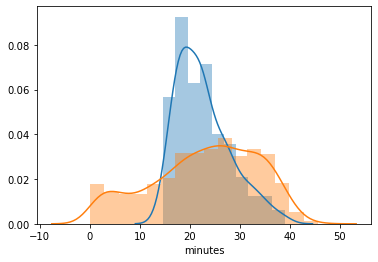

In [52]:
late_jan_box_scores["minutes"] = late_jan_box_scores["seconds_played"] / 60
# sns.distplot(jan_24_pred_actual.minutes)
sns.distplot(july_31_predictions.minutes)
sns.distplot(late_jan_box_scores.minutes)
# sns.distplot(feb_12_pred_actual.minutes)
#sns.jointplot(data = feb_12_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
#sns.jointplot(data = jan_24_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
# sns.distplot(feb_12_pred_actual.actual_points)
# sns.distplot(feb_12_pred_actual.predicted_points)

In [30]:
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SAC':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
dkp = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dkp = dkp[pd.isna(dkp.position)==False]
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')

ranks = []
seen = {}
player_names = [seen.setdefault(x, x) for x in dkp['name'] if x not in seen]
abbrv = [str(dkp.loc[dkp['name']==x, 'team'].iloc[0]).upper() for x in player_names]
player_positions = [dkp.loc[dkp['name']==x, 'position'].iloc[0] for x in player_names]
team_names = [all_abbrv.get(x) for x in abbrv]

for i in range(0, len(player_names)):
    if len(player_positions[i])<=2:
        ranks.append(dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i])].iloc[0])
    else:
        first_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][:2])].iloc[0]
        second_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][3:])].iloc[0]
        ranks.append((first_subrank + second_subrank)/2)

outputDefense = pd.DataFrame({'name':player_names, 'pos':player_positions, 'team':team_names, 'rank':ranks})
outputDefense.to_csv('./OutputCSVs/player_def_vs_position.csv', header=True, index=False)

In [3]:
import unicodedata

def strip_accents(text):
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

team_def_vs_pos = []
opp_def_vs_pos = []
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SACRAMENTO KINGS':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
main_df = pd.read_csv('./AllCSVs/predictions_for_07_31_2020_unplayed.csv')
dk_positions = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')
dk_positions.dropna(subset=['position'],inplace=True)
player_positions = pd.Series(dk_positions.position.values,index=dk_positions.name).to_dict()
for i in range(len(main_df)):
    name = strip_accents(main_df['name'][i])
    position = player_positions.get(name)
    team = all_abbrv.get(main_df['team'][i])
    opponent = all_abbrv.get(main_df['opponent'][i])
    if position is None:
        team_def_vs_pos.append('NA')
        opp_def_vs_pos.append('NA')
    else:
        if len(position)<=2:
            team_def_vs_pos.append(dbp.loc[dbp['Team']==team, 'vs {0}'.format(position)].iloc[0])
            opp_def_vs_pos.append(dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position)].iloc[0])
        else:
            first_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[:2])].iloc[0]
            second_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[3:])].iloc[0]
            first_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[:2])].iloc[0]
            second_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[3:])].iloc[0]
            team_def_vs_pos.append((first_team_subrank + second_team_subrank)/2)
            opp_def_vs_pos.append((first_opp_subrank + second_opp_subrank)/2)
main_df['team def vs pos'] = team_def_vs_pos
main_df['opponent def vs pos'] = opp_def_vs_pos
main_df.to_csv('AllCSVs/predictions_for_07_31_2020_unplayed.csv')

TypeError: normalize() argument 2 must be str, not float